
House Price Prediction - Advanced regression Assignment
------------------------------------------------------------------------------------------------------

The solution is divided into the following sections:

    Data understanding and exploration
    Data cleaning
    Data preparation
    Model building and evaluation
    Observation and inference



In [1]:
# Importing libs
import os
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import copy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize, add_dummy_feature, OneHotEncoder
from sklearn.feature_selection import RFE
from sklearn.linear_model import Ridge, Lasso, LinearRegression

In [2]:
# Reading CSV file
dataframe = pd.read_csv("./train.csv")
dataframe.head(2)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  

[2 rows x 81 columns]

In [3]:
# Check the dimensions
dataframe.shape

(1460, 81)

In [4]:
# We will drop Id since it is index.
droped_df = dataframe.drop(["Id"], axis=1)

<Axes: >

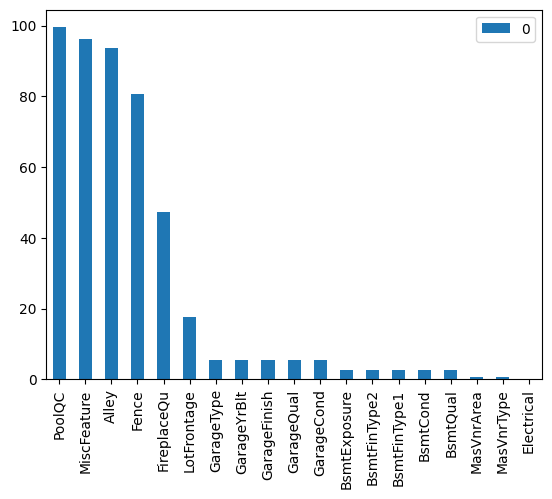

In [5]:
# Ploting NA percentage
na_df = dataframe.isna().sum().to_frame()
na_df = na_df[na_df[0]!=0]

na_df[0] = na_df[0]/len(dataframe)*100

na_df.sort_values(by=0, ascending=False).plot.bar()

### We will not remove categorial columns with na values since here na meaning not available.

In [6]:
types = droped_df.dtypes

In [7]:
# Now defining type of columns
numerical = types[types!="object"].index
categorical = types[types=="object"].index
print(f"Numeric : {len(numerical)} \nCategoric : {len(categorical)}")

Numeric : 37 
Categoric : 43


In [8]:
# Doing a check if any categorical is actully numerical.
for i in categorical:
    print(i.ljust(20), droped_df[i].unique()[:3])

MSZoning             ['RL' 'RM' 'C (all)']
Street               ['Pave' 'Grvl']
Alley                [nan 'Grvl' 'Pave']
LotShape             ['Reg' 'IR1' 'IR2']
LandContour          ['Lvl' 'Bnk' 'Low']
Utilities            ['AllPub' 'NoSeWa']
LotConfig            ['Inside' 'FR2' 'Corner']
LandSlope            ['Gtl' 'Mod' 'Sev']
Neighborhood         ['CollgCr' 'Veenker' 'Crawfor']
Condition1           ['Norm' 'Feedr' 'PosN']
Condition2           ['Norm' 'Artery' 'RRNn']
BldgType             ['1Fam' '2fmCon' 'Duplex']
HouseStyle           ['2Story' '1Story' '1.5Fin']
RoofStyle            ['Gable' 'Hip' 'Gambrel']
RoofMatl             ['CompShg' 'WdShngl' 'Metal']
Exterior1st          ['VinylSd' 'MetalSd' 'Wd Sdng']
Exterior2nd          ['VinylSd' 'MetalSd' 'Wd Shng']
MasVnrType           ['BrkFace' 'None' 'Stone']
ExterQual            ['Gd' 'TA' 'Ex']
ExterCond            ['TA' 'Gd' 'Fa']
Foundation           ['PConc' 'CBlock' 'BrkTil']
BsmtQual             ['Gd' 'TA' 'Ex']
BsmtCond   

In [9]:
# No numerical values is present in categorical columns that we have to transform

In [10]:
filling_df = pd.DataFrame(droped_df)

In [11]:
# 1 Outlier is there and mean is around 75
# we will fill na with mean since this is aprox normal plot

filling_df["LotFrontage"] = droped_df["LotFrontage"].fillna(droped_df["LotFrontage"].mean())

In [12]:
# We will check defination of categorical column before filling na values.
categorical

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [13]:
# Checking which categorical have na values
cat_na = filling_df[categorical].isna().sum().to_frame()
cat_na = cat_na[cat_na[0]!=0]
cat_na

0
Alley         1369
MasVnrType       8
BsmtQual        37
BsmtCond        37
BsmtExposure    38
BsmtFinType1    37
BsmtFinType2    38
Electrical       1
FireplaceQu    690
GarageType      81
GarageFinish    81
GarageQual      81
GarageCond      81
PoolQC        1453
Fence         1179
MiscFeature   1406

In [14]:
print("NA values of MasVnrType", filling_df["MasVnrType"].isna().sum())
print("Unique values\n", filling_df["MasVnrType"].value_counts())
# We can see that None and NA are different in this column, We will fill na with None.
filling_df["MasVnrType"] = filling_df["MasVnrType"].fillna("None")

NA values of MasVnrType 8
Unique values
 None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64


In [15]:
print("NA values of Electrical", filling_df["Electrical"].isna().sum())
print("Unique values\n", filling_df["Electrical"].value_counts())
# We can see that None and NA are different in this column, We will fill na with None or None with SBrkr
filling_df["Electrical"] = filling_df["Electrical"].fillna("SBrkr")

NA values of Electrical 1
Unique values
 SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64


**Alley, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, FireplaceQu, GarageType, GarageFinish, GarageQual, GarageCond, PoolQC, Fence, MiscFeature can have na values we will replace it with None string for now.**

In [16]:
for col in "Alley, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, FireplaceQu, GarageType, GarageFinish, GarageQual, GarageCond, PoolQC, Fence, MiscFeature".split(", "):
    filling_df[col] = filling_df[col].fillna("None")

In [17]:
# Checking which categorical have na values
cat_na = filling_df[categorical].isna().sum().to_frame()
cat_na = cat_na[cat_na[0]!=0]
cat_na

Empty DataFrame
Columns: [0]
Index: []

In [18]:
# Checking which numerical have na values
num_na = filling_df[numerical].isna().sum().to_frame()
num_na = num_na[num_na[0]!=0]
num_na

0
MasVnrArea    8
GarageYrBlt  81

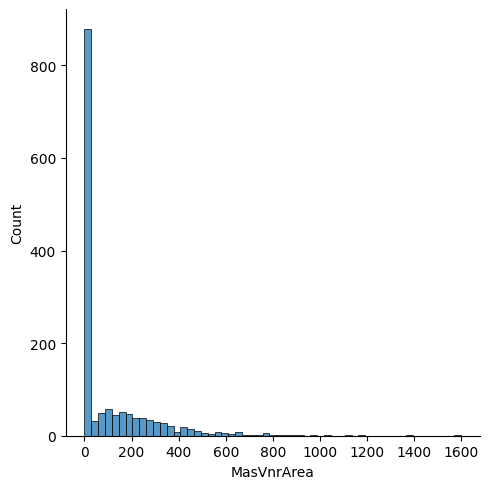

In [19]:
# MasVnrArea
sns.displot(filling_df["MasVnrArea"])
# most values are zero

In [20]:
# Checking if all zero values are None in MasVnrType
print(filling_df[filling_df["MasVnrArea"]==0]["MasVnrType"].value_counts())
# We can see there are 1 BrkFace and 1 Stone value in 0 size Veneer, so we will replace them with None
print(filling_df[(filling_df["MasVnrArea"]==0) & ((filling_df["MasVnrType"]=="BrkFace") | (filling_df["MasVnrType"]=="Stone"))]["MasVnrType"])
filling_df.loc[[688, 1241], "MasVnrType"] = "None"

None       859
BrkFace      1
Stone        1
Name: MasVnrType, dtype: int64
688     BrkFace
1241      Stone
Name: MasVnrType, dtype: object


In [21]:
# Checking if all zero values are NA in MasVnrType
print(filling_df[filling_df["MasVnrArea"].isna()]["MasVnrType"])
# All zero values are None, we can fill na with 0.
filling_df["MasVnrArea"] = filling_df["MasVnrArea"].fillna(0)

234     None
529     None
650     None
936     None
973     None
977     None
1243    None
1278    None
Name: MasVnrType, dtype: object


/tmp/ipykernel_15013/3909064197.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(filling_df["GarageYrBlt"])


<Axes: xlabel='GarageYrBlt', ylabel='Density'>

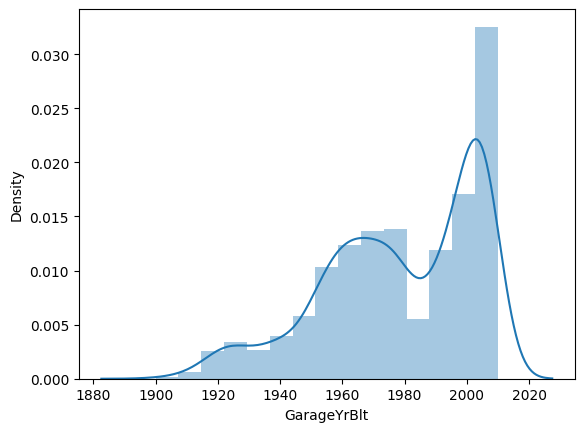

In [22]:
# GarageYrBlt
sns.distplot(filling_df["GarageYrBlt"])

In [23]:
# Graph is exponential so we will apply log on it. and fill na with mean
filling_df["GarageYrBlt"] = filling_df["GarageYrBlt"].fillna(filling_df["GarageYrBlt"].mean())

In [24]:
filling_df.isna().sum().sum()

0

# Transforming

In [25]:
# Finding columns which are continous numeric and not descreet numeric
sorted([(len(filling_df[col].unique()), col, filling_df[col].unique()[:3]) for col in numerical])

[(3, 'BsmtHalfBath', array([0, 1, 2])),
 (3, 'HalfBath', array([1, 0, 2])),
 (4, 'BsmtFullBath', array([1, 0, 2])),
 (4, 'Fireplaces', array([0, 1, 2])),
 (4, 'FullBath', array([2, 1, 3])),
 (4, 'KitchenAbvGr', array([1, 2, 3])),
 (5, 'GarageCars', array([2, 3, 1])),
 (5, 'YrSold', array([2008, 2007, 2006])),
 (8, 'BedroomAbvGr', array([3, 4, 1])),
 (8, 'PoolArea', array([  0, 512, 648])),
 (9, 'OverallCond', array([5, 8, 6])),
 (10, 'OverallQual', array([7, 6, 8])),
 (12, 'MoSold', array([2, 5, 9])),
 (12, 'TotRmsAbvGrd', array([8, 6, 7])),
 (15, 'MSSubClass', array([60, 20, 70])),
 (20, '3SsnPorch', array([  0, 320, 407])),
 (21, 'MiscVal', array([  0, 700, 350])),
 (24, 'LowQualFinSF', array([  0, 360, 513])),
 (61, 'YearRemodAdd', array([2003, 1976, 2002])),
 (76, 'ScreenPorch', array([  0, 176, 198])),
 (98, 'GarageYrBlt', array([2003., 1976., 2001.])),
 (111, 'LotFrontage', array([65., 80., 68.])),
 (112, 'YearBuilt', array([2003, 1976, 2001])),
 (120, 'EnclosedPorch', array([  0

In [26]:
# Working on feature having unique values more then 25

In [27]:
true_numeric = [col for col in numerical if len(filling_df[col].unique())>25]
false_numeric = [col for col in numerical if len(filling_df[col].unique())<=25]


In [28]:
# Removing feature which are year
year_num = ["YrSold", "YearRemodAdd", "GarageYrBlt", "YearBuilt"]

In [29]:
# Removing year feature from true num
true_numeric = [col for col in true_numeric if col not in year_num]
false_numeric = [col for col in false_numeric if col not in year_num]


In [30]:
true_numeric

['LotFrontage',
 'LotArea',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 'ScreenPorch',
 'SalePrice']

In [31]:
assert len(numerical) == len(year_num)+len(true_numeric)+len(false_numeric)

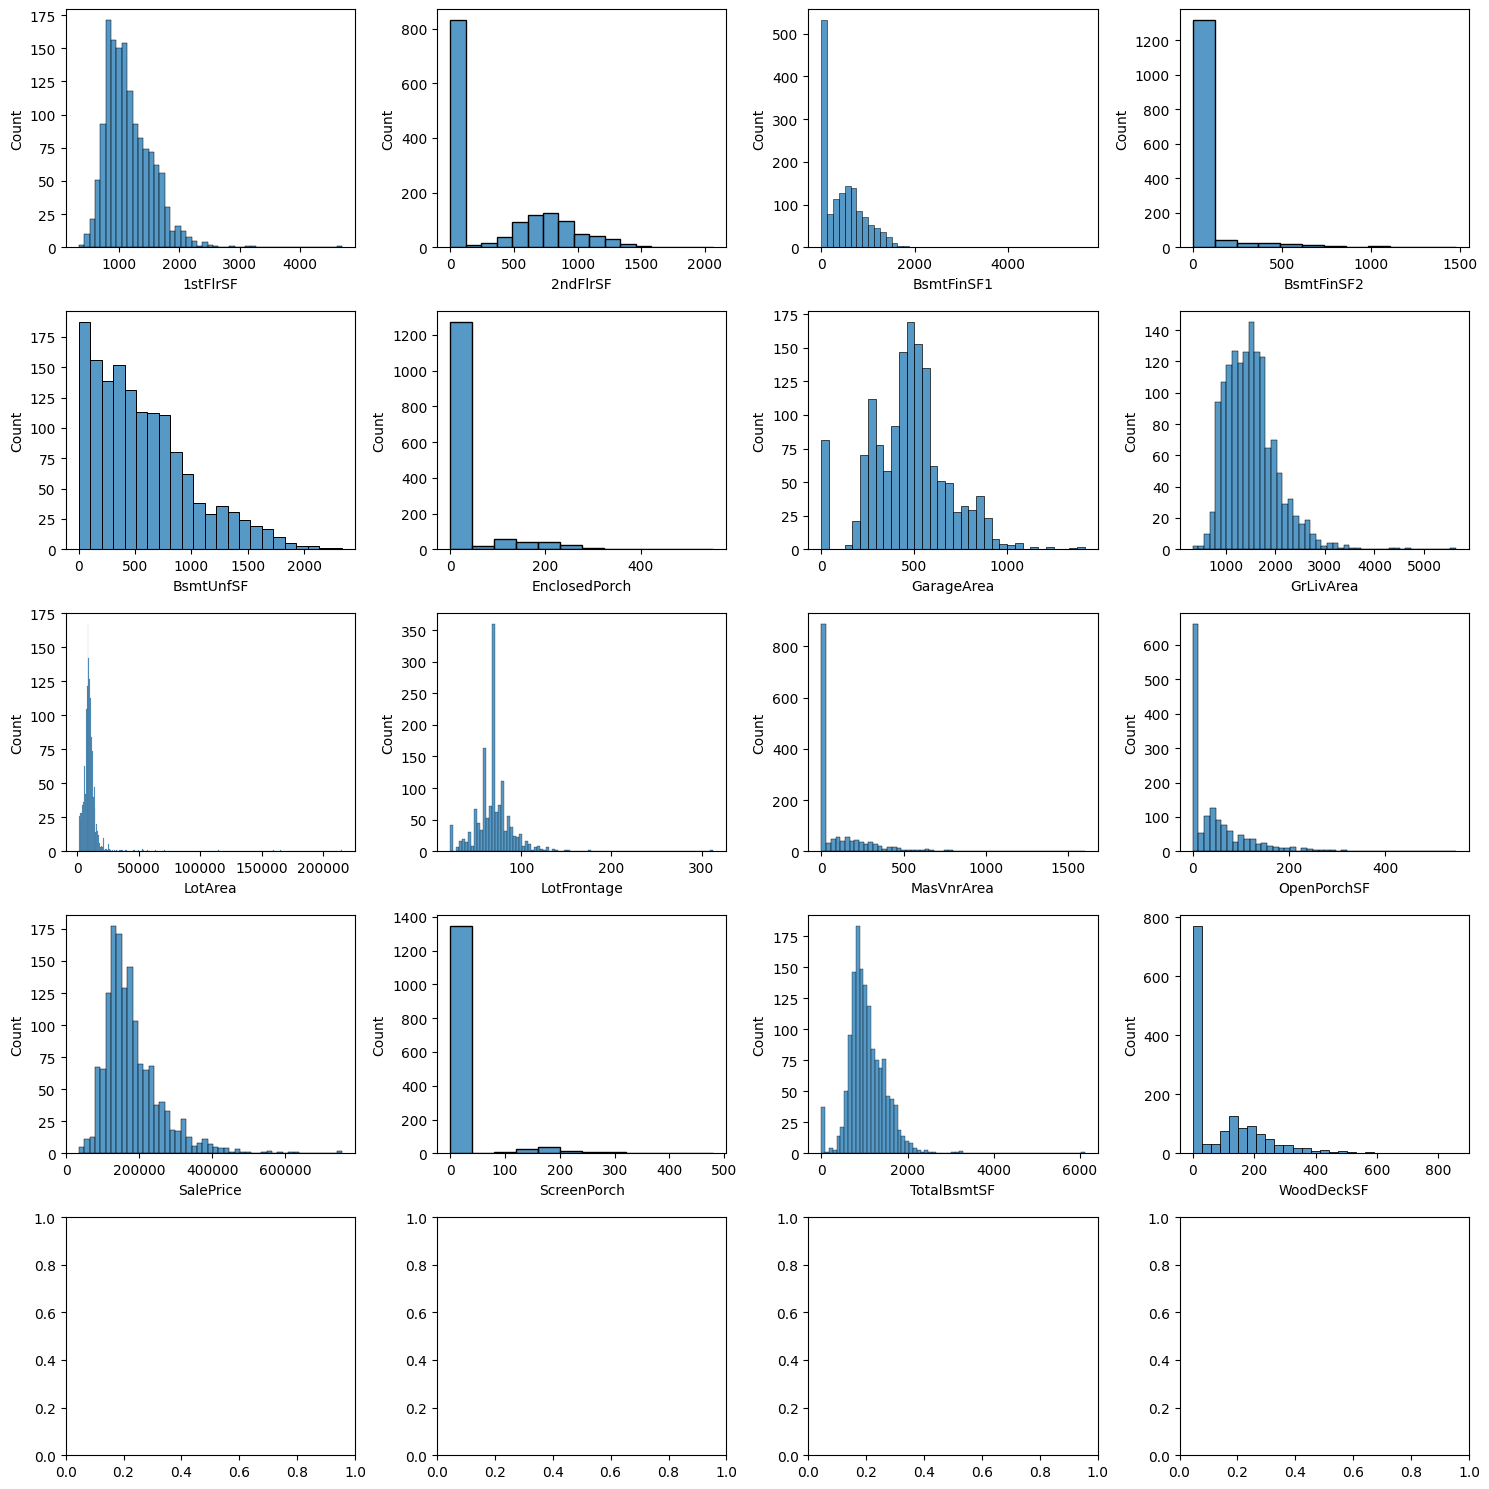

In [32]:
# Ploting numerical values
fig, ax = plt.subplots(nrows = len(true_numeric)//4+1, ncols=4, figsize=(15,15))
ax=  np.ravel(ax)
for itr, num_col in enumerate(sorted(true_numeric)):
    sns.histplot(filling_df[num_col], ax = ax[itr])
plt.tight_layout()

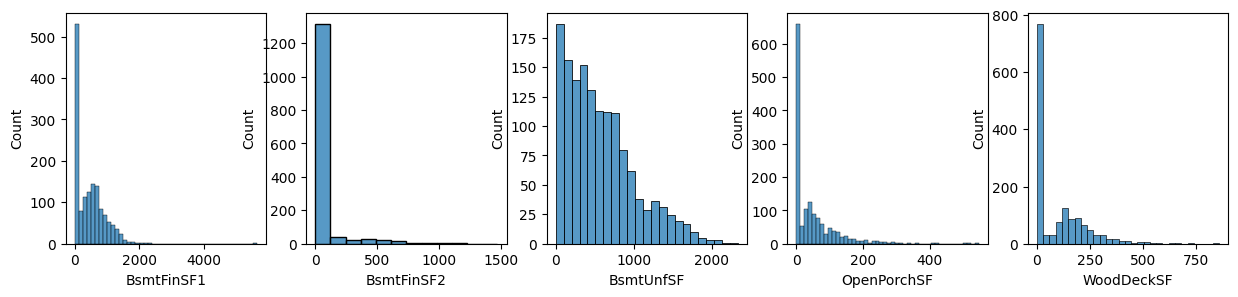

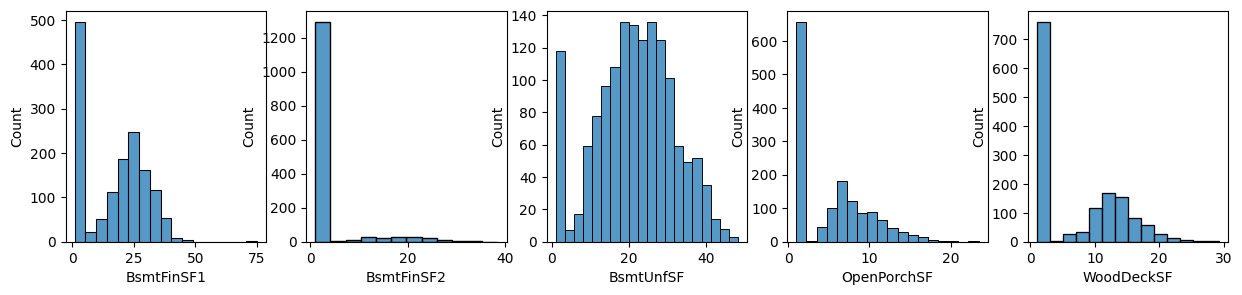

In [33]:
sqew_features = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'OpenPorchSF', 'WoodDeckSF']
fig, ax = plt.subplots(1, 5, figsize=(15,3))
for itr, col in enumerate(sqew_features):
    sns.histplot(filling_df[col], ax=ax[itr])
# Sqrt transformation
fig, ax = plt.subplots(1, 5, figsize=(15,3))
for itr, col in enumerate(sqew_features):
    sns.histplot(np.sqrt(filling_df[col]+1), ax=ax[itr])


In [34]:
transform_df = copy.deepcopy(filling_df)

In [35]:
for col in sqew_features:
    transform_df[col] = np.sqrt(filling_df[col])

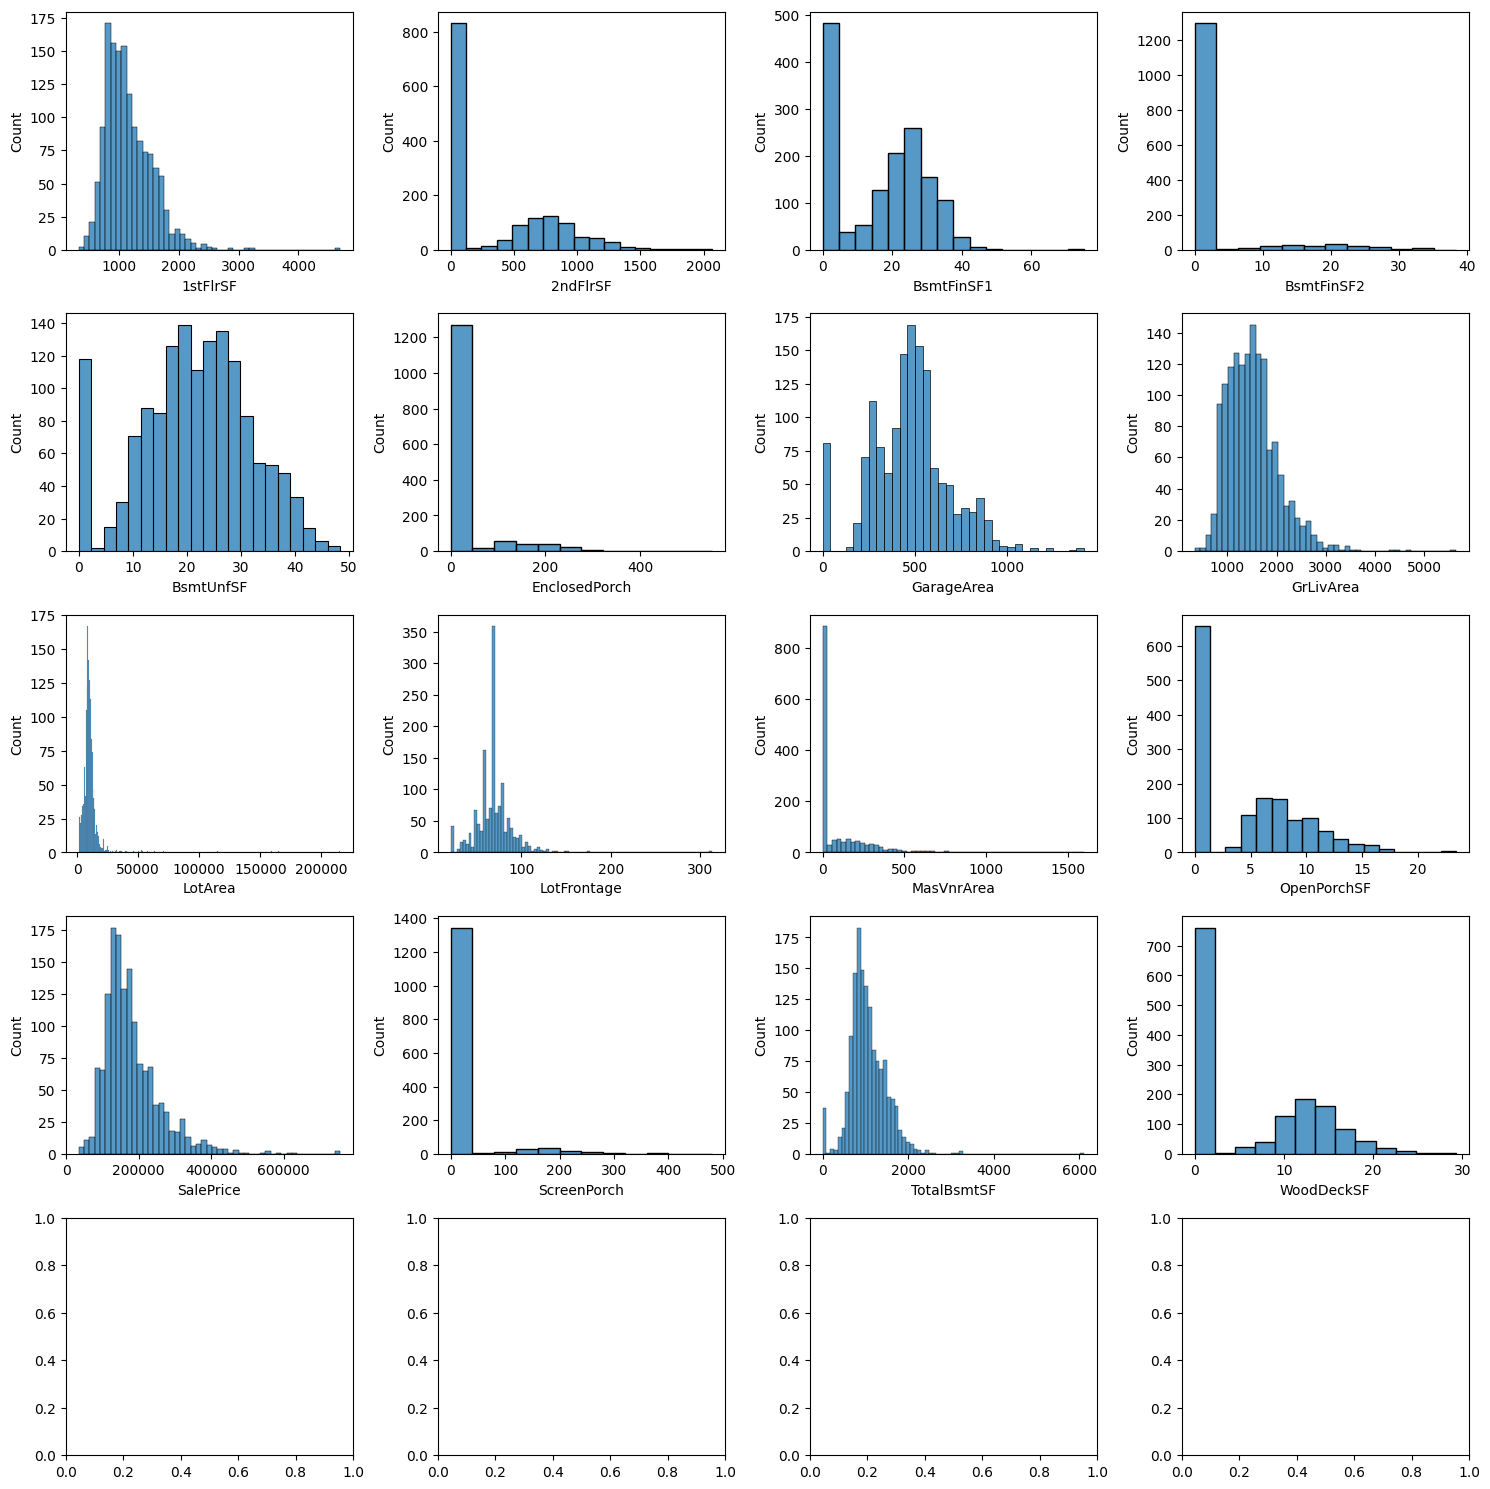

In [36]:
# Ploting numerical values
fig, ax = plt.subplots(nrows = len(true_numeric)//4+1, ncols=4, figsize=(15,15))
ax=  np.ravel(ax)
for itr, num_col in enumerate(sorted(true_numeric)):
    sns.histplot(transform_df[num_col], ax = ax[itr])
plt.tight_layout()

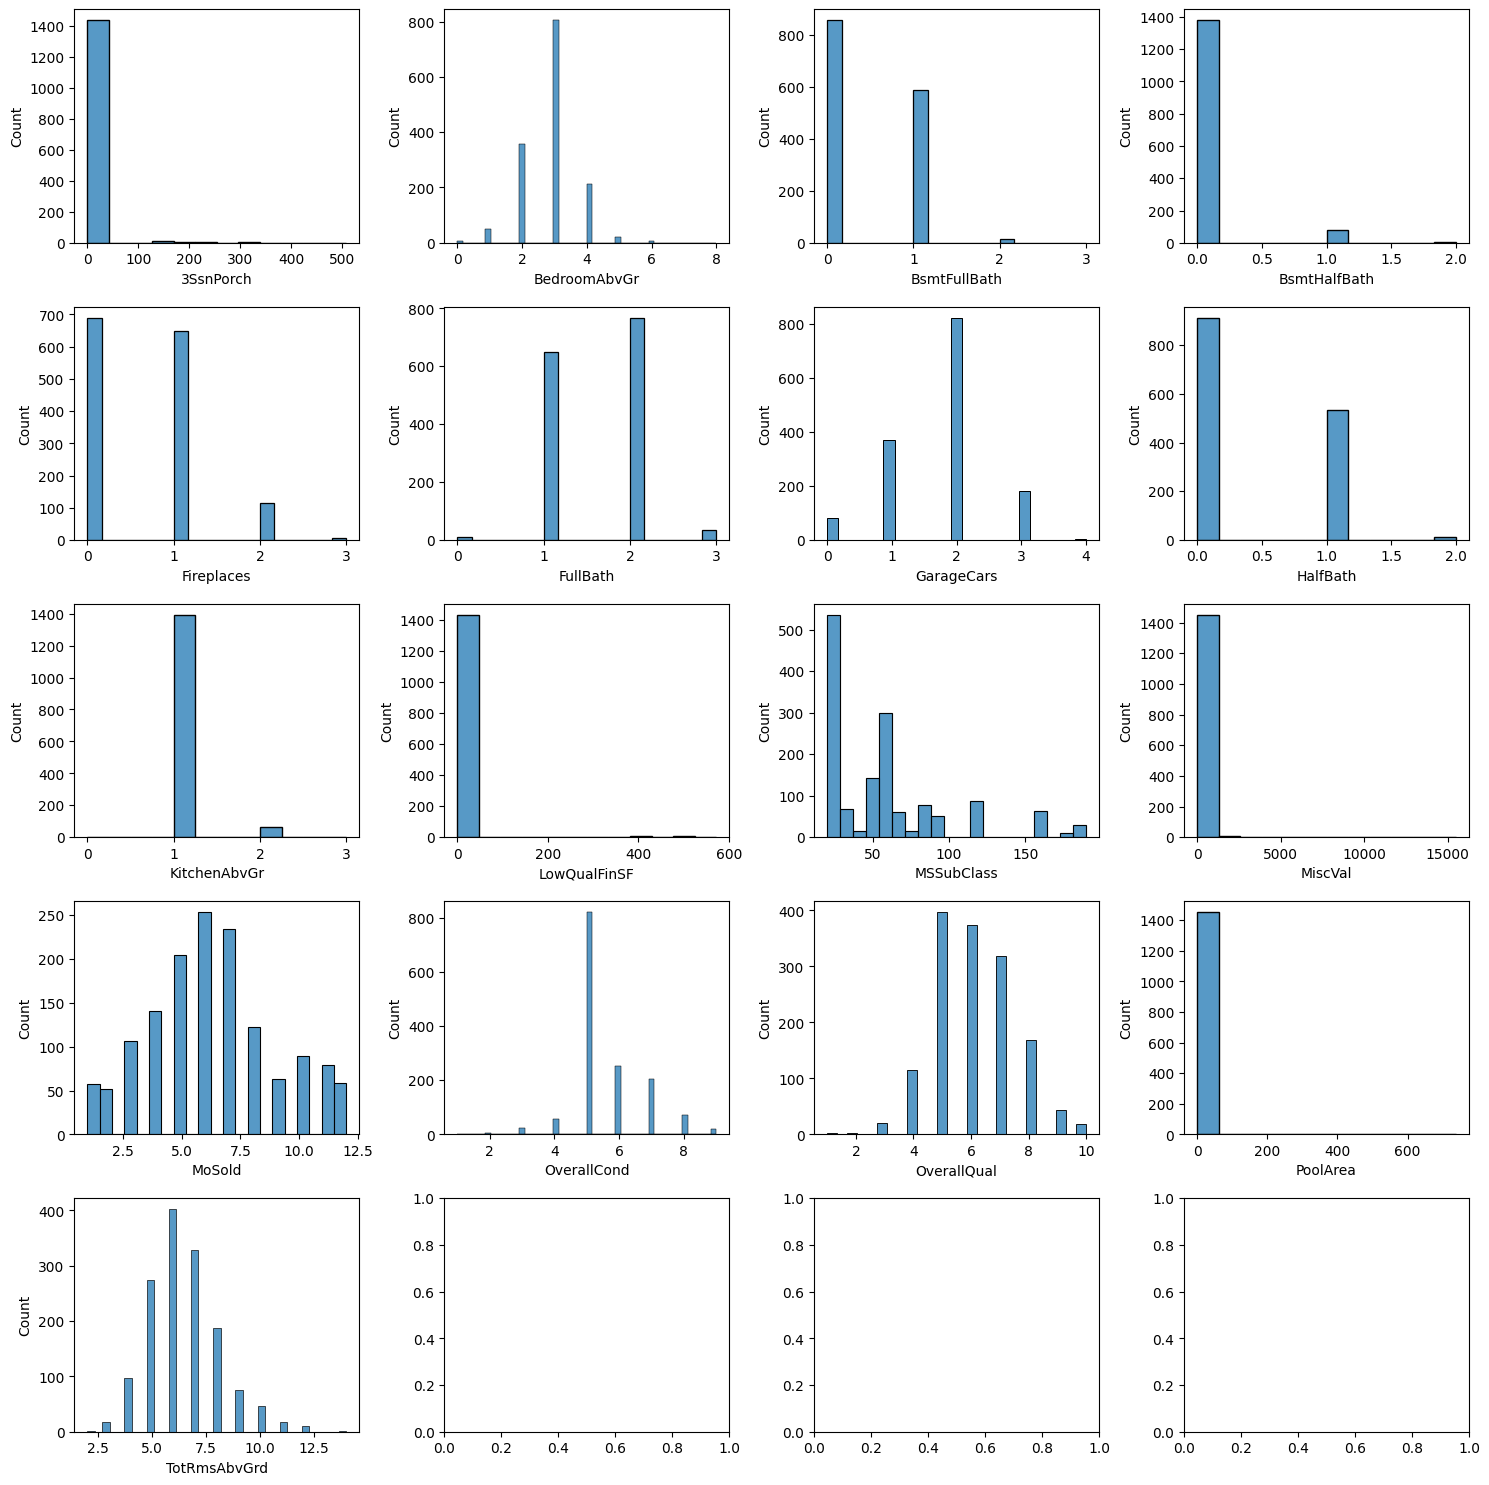

In [37]:
# Ploting  descrete numerical values
fig, ax = plt.subplots(nrows = len(false_numeric)//4+1, ncols=4, figsize=(15,15))
ax=  np.ravel(ax)
for itr, num_col in enumerate(sorted(false_numeric)):
    sns.histplot(transform_df[num_col], ax = ax[itr])
plt.tight_layout()

**Plots looks close to normal now**

In [38]:
describe = transform_df.describe().T.sort_index()
extream_outliers = describe[(describe['75%']+3*describe['std'])<describe['max']]
extream_outliers

count           mean           std      min        25%  \
1stFlrSF       1460.0    1162.626712    386.587738    334.0     882.00   
2ndFlrSF       1460.0     346.992466    436.528436      0.0       0.00   
3SsnPorch      1460.0       3.409589     29.317331      0.0       0.00   
BedroomAbvGr   1460.0       2.866438      0.815778      0.0       2.00   
BsmtFinSF1     1460.0      16.454910     13.152724      0.0       0.00   
BsmtFinSF2     1460.0       2.163244      6.472897      0.0       0.00   
BsmtFullBath   1460.0       0.425342      0.518911      0.0       0.00   
BsmtHalfBath   1460.0       0.057534      0.238753      0.0       0.00   
EnclosedPorch  1460.0      21.954110     61.119149      0.0       0.00   
Fireplaces     1460.0       0.613014      0.644666      0.0       0.00   
GarageArea     1460.0     472.980137    213.804841      0.0     334.50   
GrLivArea      1460.0    1515.463699    525.480383    334.0    1129.50   
KitchenAbvGr   1460.0       1.046575      0.220338      0.0       1.00   
LotArea        1460.0   10516.828082   9981.264932   1300.0    7553.50   
LotFrontage    1460.0      70.049958     22.024023     21.0      60.00   
LowQualFinSF   1460.0       5.844521     48.623081      0.0       0.00   
MasVnrArea     1460.0     103.117123    180.731373      0.0       0.00   
MiscVal        1460.0      43.489041    496.123024      0.0       0.00   
OpenPorchSF    1460.0       4.741895      4.918462      0.0       0.00   
PoolArea       1460.0       2.758904     40.177307      0.0       0.00   
SalePrice      1460.0  180921.195890  79442.502883  34900.0  129975.00   
ScreenPorch    1460.0      15.060959     55.757415      0.0       0.00   
TotRmsAbvGrd   1460.0       6.517808      1.625393      2.0       5.00   
TotalBsmtSF    1460.0    1057.429452    438.705324      0.0     795.75   

                         50%            75%            max  
1stFlrSF         1087.000000    1391.250000    4692.000000  
2ndFlrSF            0.000000     728.000000    2065.000000  
3SsnPorch           0.000000       0.000000     508.000000  
BedroomAbvGr        3.000000       3.000000       8.000000  
BsmtFinSF1         19.583152      26.688011      75.126560  
BsmtFinSF2          0.000000       0.000000      38.392708  
BsmtFullBath        0.000000       1.000000       3.000000  
BsmtHalfBath        0.000000       0.000000       2.000000  
EnclosedPorch       0.000000       0.000000     552.000000  
Fireplaces          1.000000       1.000000       3.000000  
GarageArea        480.000000     576.000000    1418.000000  
GrLivArea        1464.000000    1776.750000    5642.000000  
KitchenAbvGr        1.000000       1.000000       3.000000  
LotArea          9478.500000   11601.500000  215245.000000  
LotFrontage        70.049958      79.000000     313.000000  
LowQualFinSF        0.000000       0.000000     572.000000  
MasVnrArea          0.000000     164.250000    1600.000000  
MiscVal             0.000000       0.000000   15500.000000  
OpenPorchSF         5.000000       8.246211      23.388031  
PoolArea            0.000000       0.000000     738.000000  
SalePrice      163000.000000  214000.000000  755000.000000  
ScreenPorch         0.000000       0.000000     480.000000  
TotRmsAbvGrd        6.000000       7.000000      14.000000  
TotalBsmtSF       991.500000    1298.250000    6110.000000

# EDA

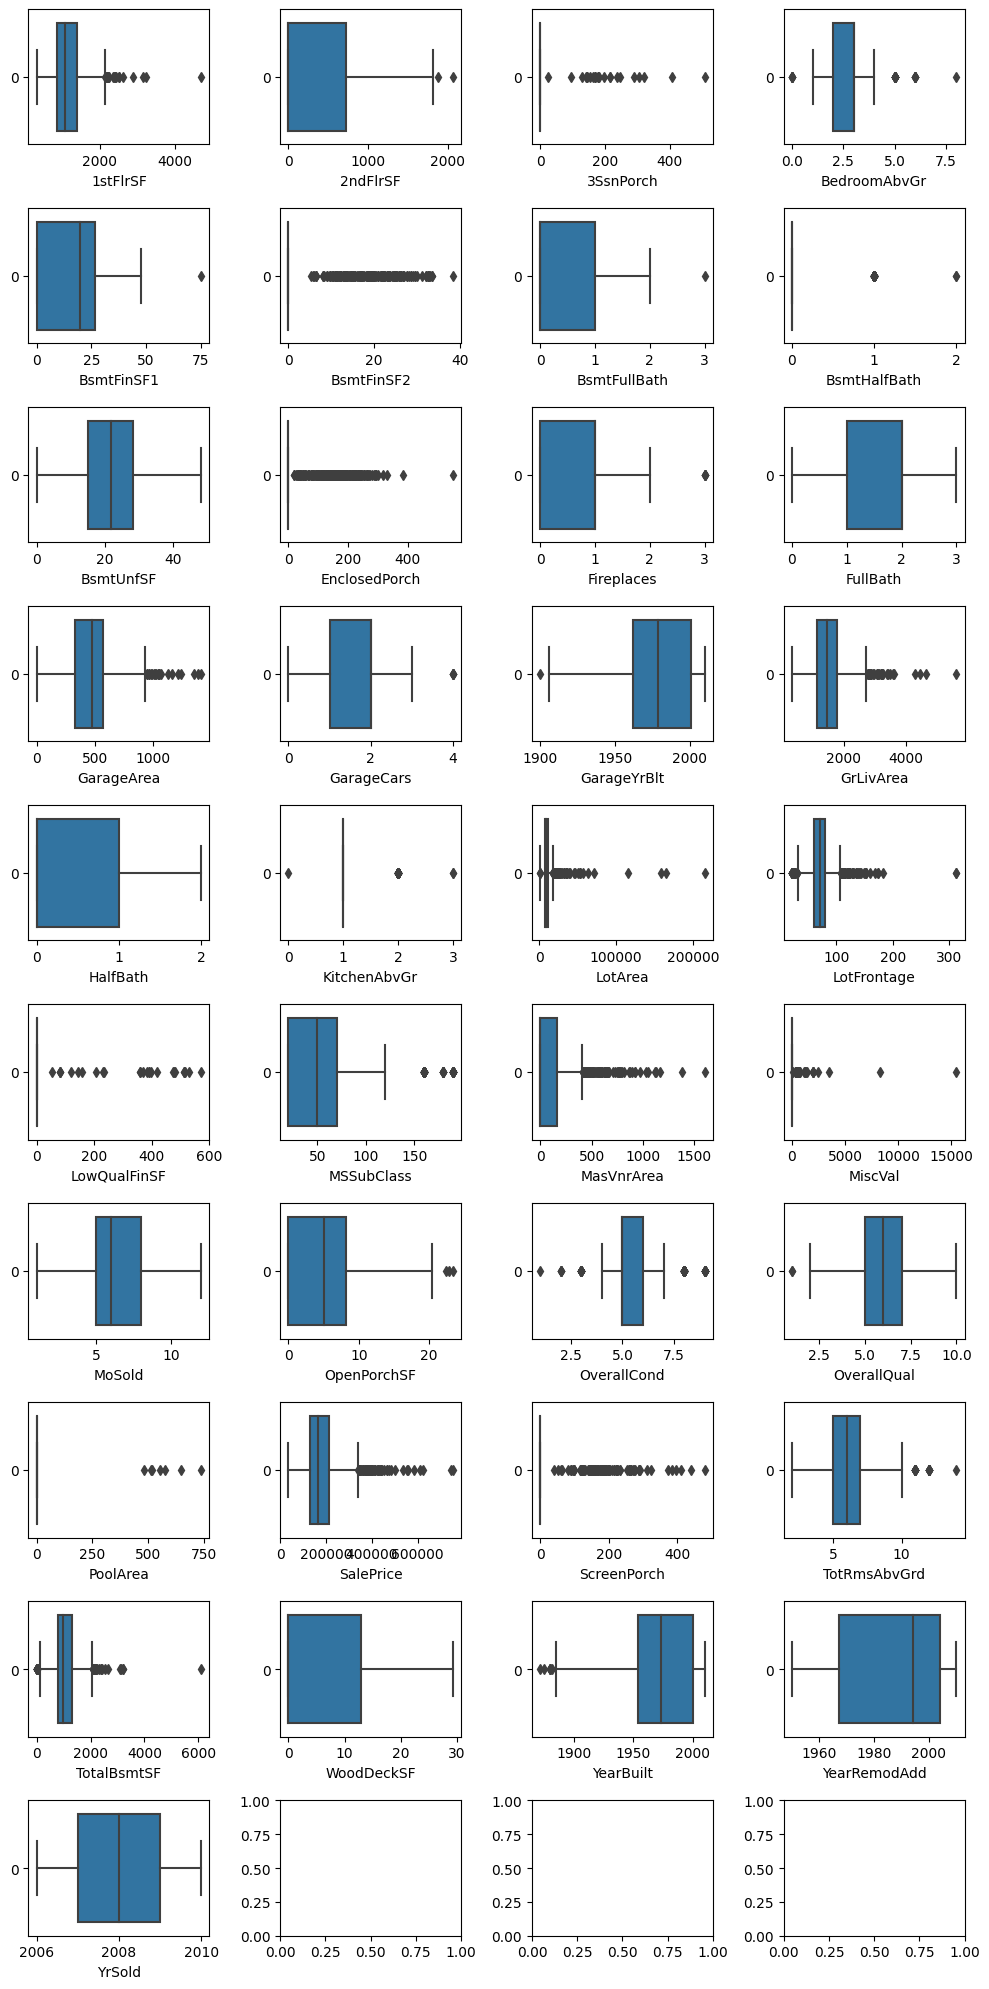

In [39]:
# Ploting  descrete numerical values
fig, ax = plt.subplots(nrows = len(numerical)//4+1, ncols=4, figsize=(10,20))
ax=  np.ravel(ax)
for itr, num_col in enumerate(sorted(numerical)):
    sns.boxplot(transform_df[num_col], ax = ax[itr], orient="h")
    ax[itr].set(xlabel=num_col)
plt.tight_layout()

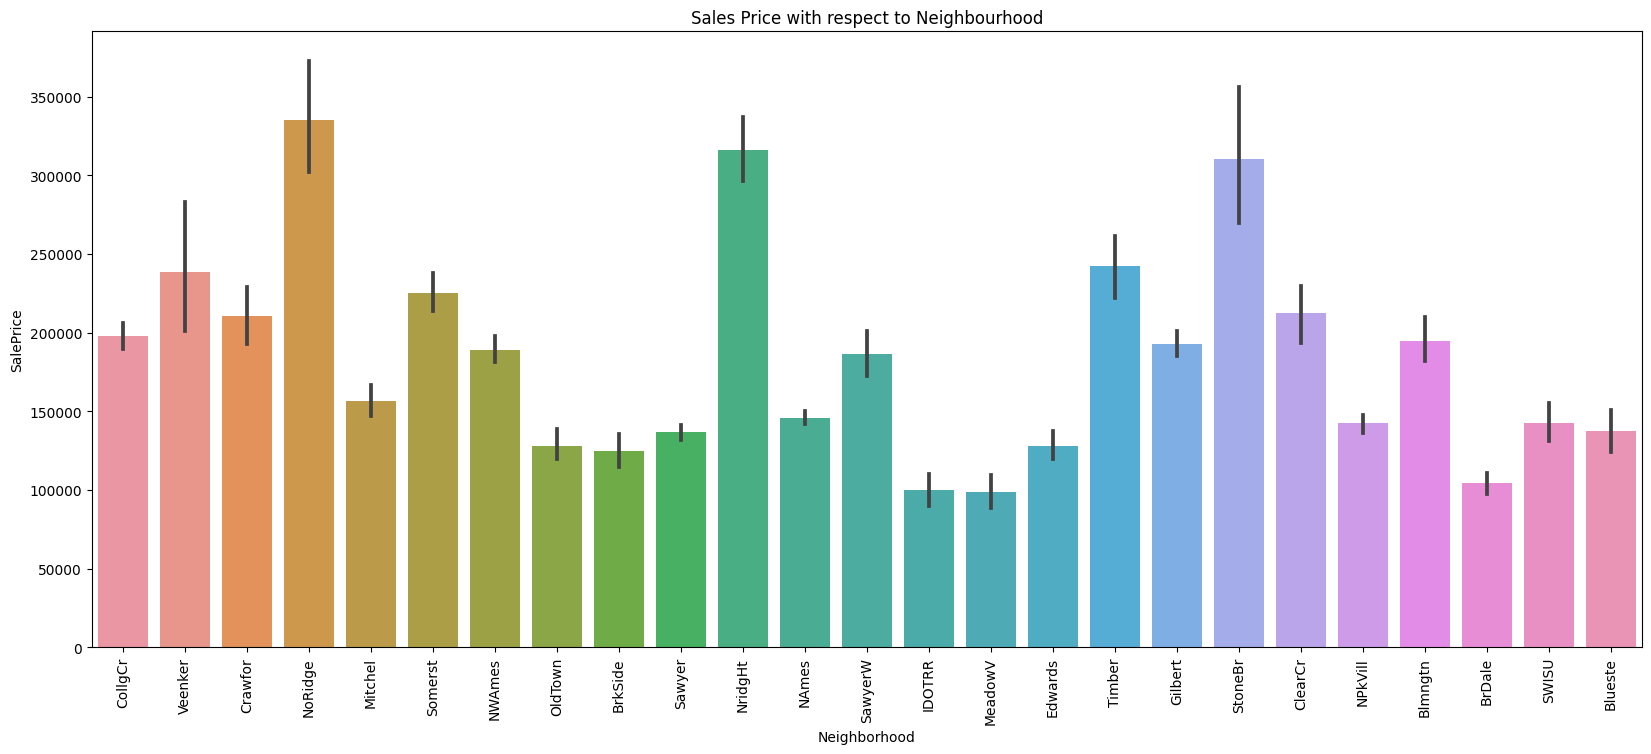

In [40]:
# plot 'Sale Price' with respect to 'Neighborhood'
plt.figure(figsize=(20, 8))
sns.barplot(x="Neighborhood", y="SalePrice", data= transform_df)
plt.title("Sales Price with respect to Neighbourhood")
_ = plt.xticks(rotation=90)

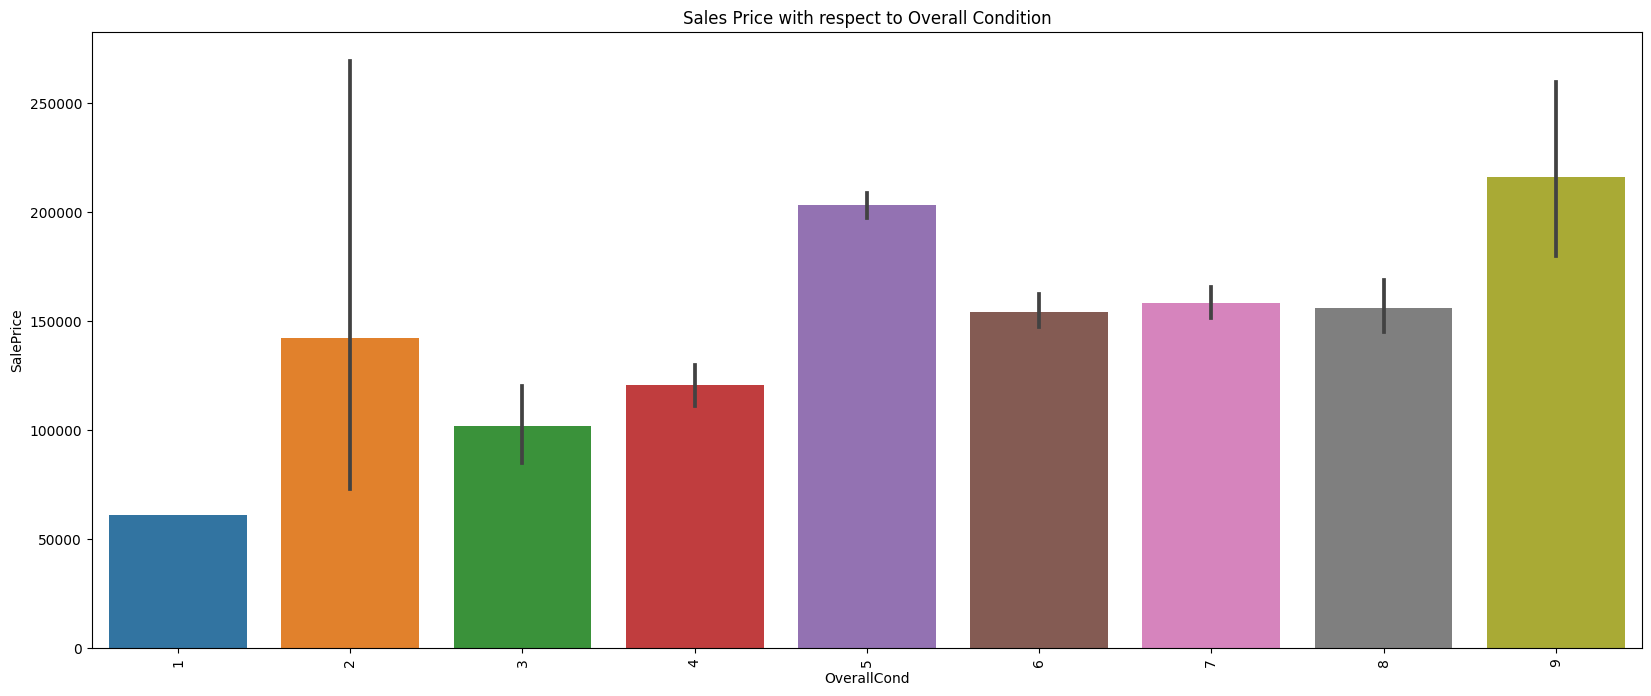

In [41]:
# plot 'overall condition' with respect to 'Saleprice'

plt.figure(figsize=(20, 8))
sns.barplot(x="OverallCond", y="SalePrice", data= transform_df)
plt.title("Sales Price with respect to Overall Condition")
_ = plt.xticks(rotation=90)

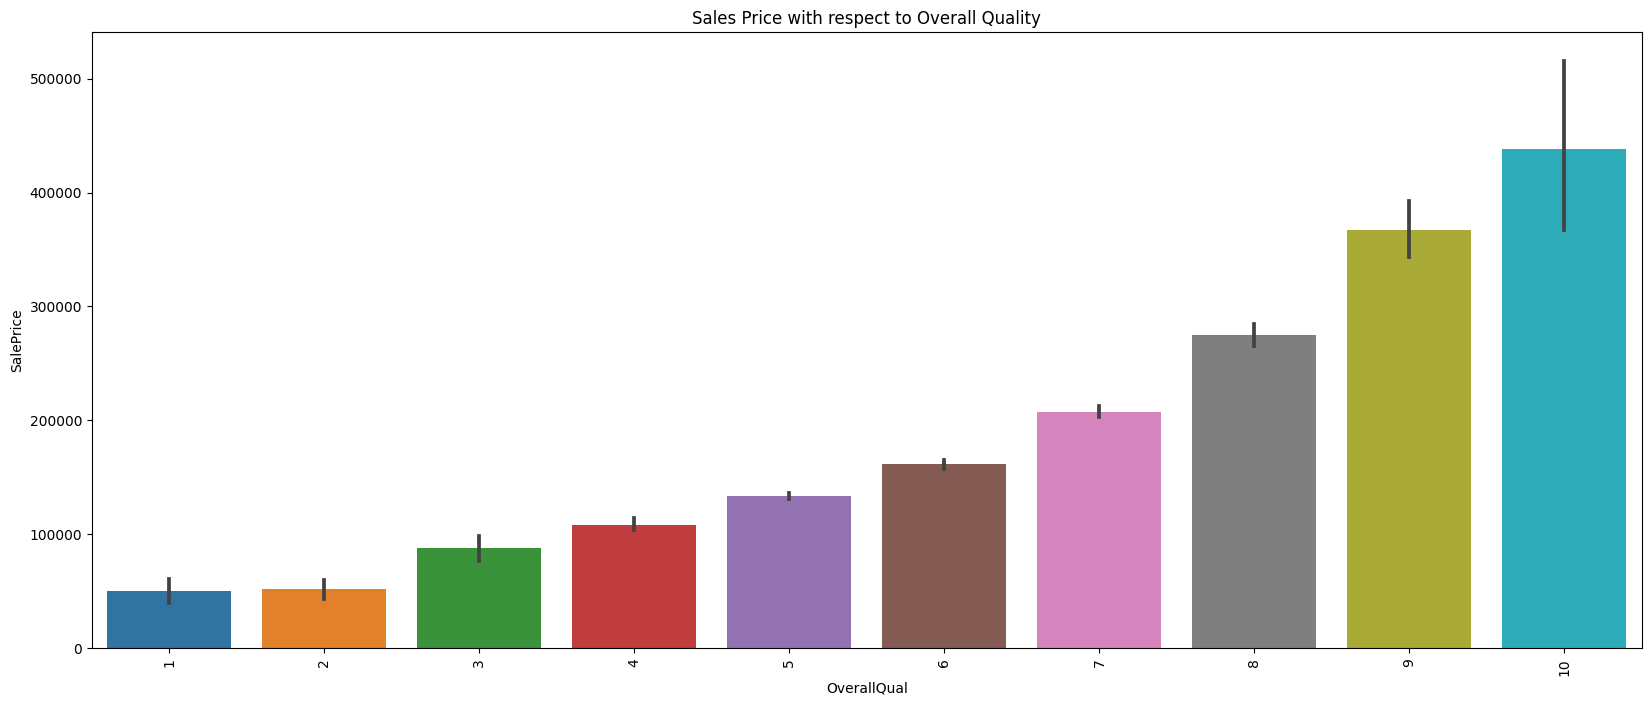

In [42]:
# plot 'overall quality' with respect to 'Saleprice'
plt.figure(figsize=(20, 8))
sns.barplot(x="OverallQual", y="SalePrice", data= transform_df)
plt.title("Sales Price with respect to Overall Quality")
_ = plt.xticks(rotation=90)

Increase in the overall quality has a direct positive effect on the sale price

/tmp/ipykernel_15013/465180688.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(transform_df['SalePrice'])


<Axes: xlabel='SalePrice', ylabel='Density'>

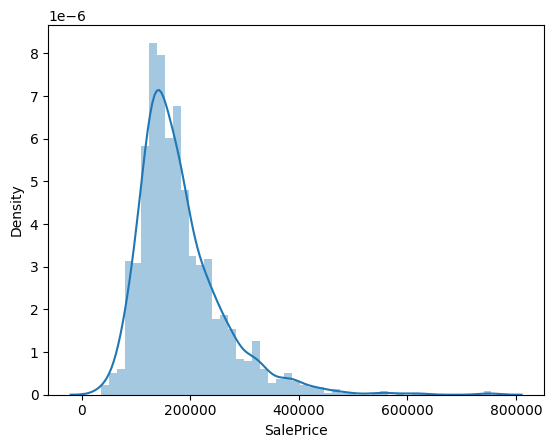

In [43]:
sns.distplot(transform_df['SalePrice'])

Since the Saleprice figures are skewed towards left, we will apply the log transformation to obtain a centralized data

In [44]:
#Log Transformation
transform_df['SalePrice']=np.log1p(transform_df['SalePrice'])

/tmp/ipykernel_15013/465180688.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(transform_df['SalePrice'])


<Axes: xlabel='SalePrice', ylabel='Density'>

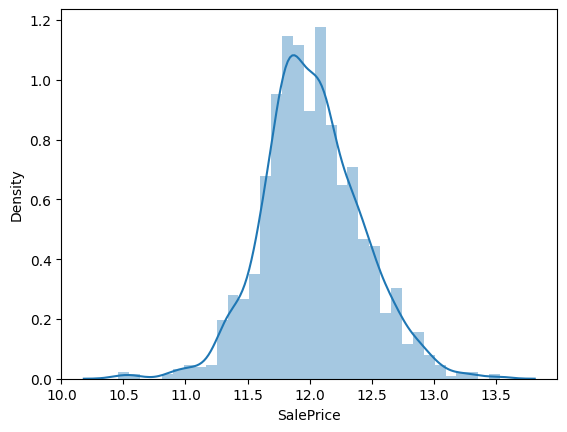

In [45]:
sns.distplot(transform_df['SalePrice'])

# plotting correlations on a heatmap

/tmp/ipykernel_15013/2225466773.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(transform_df.corr(), cmap="YlGnBu", annot=True)


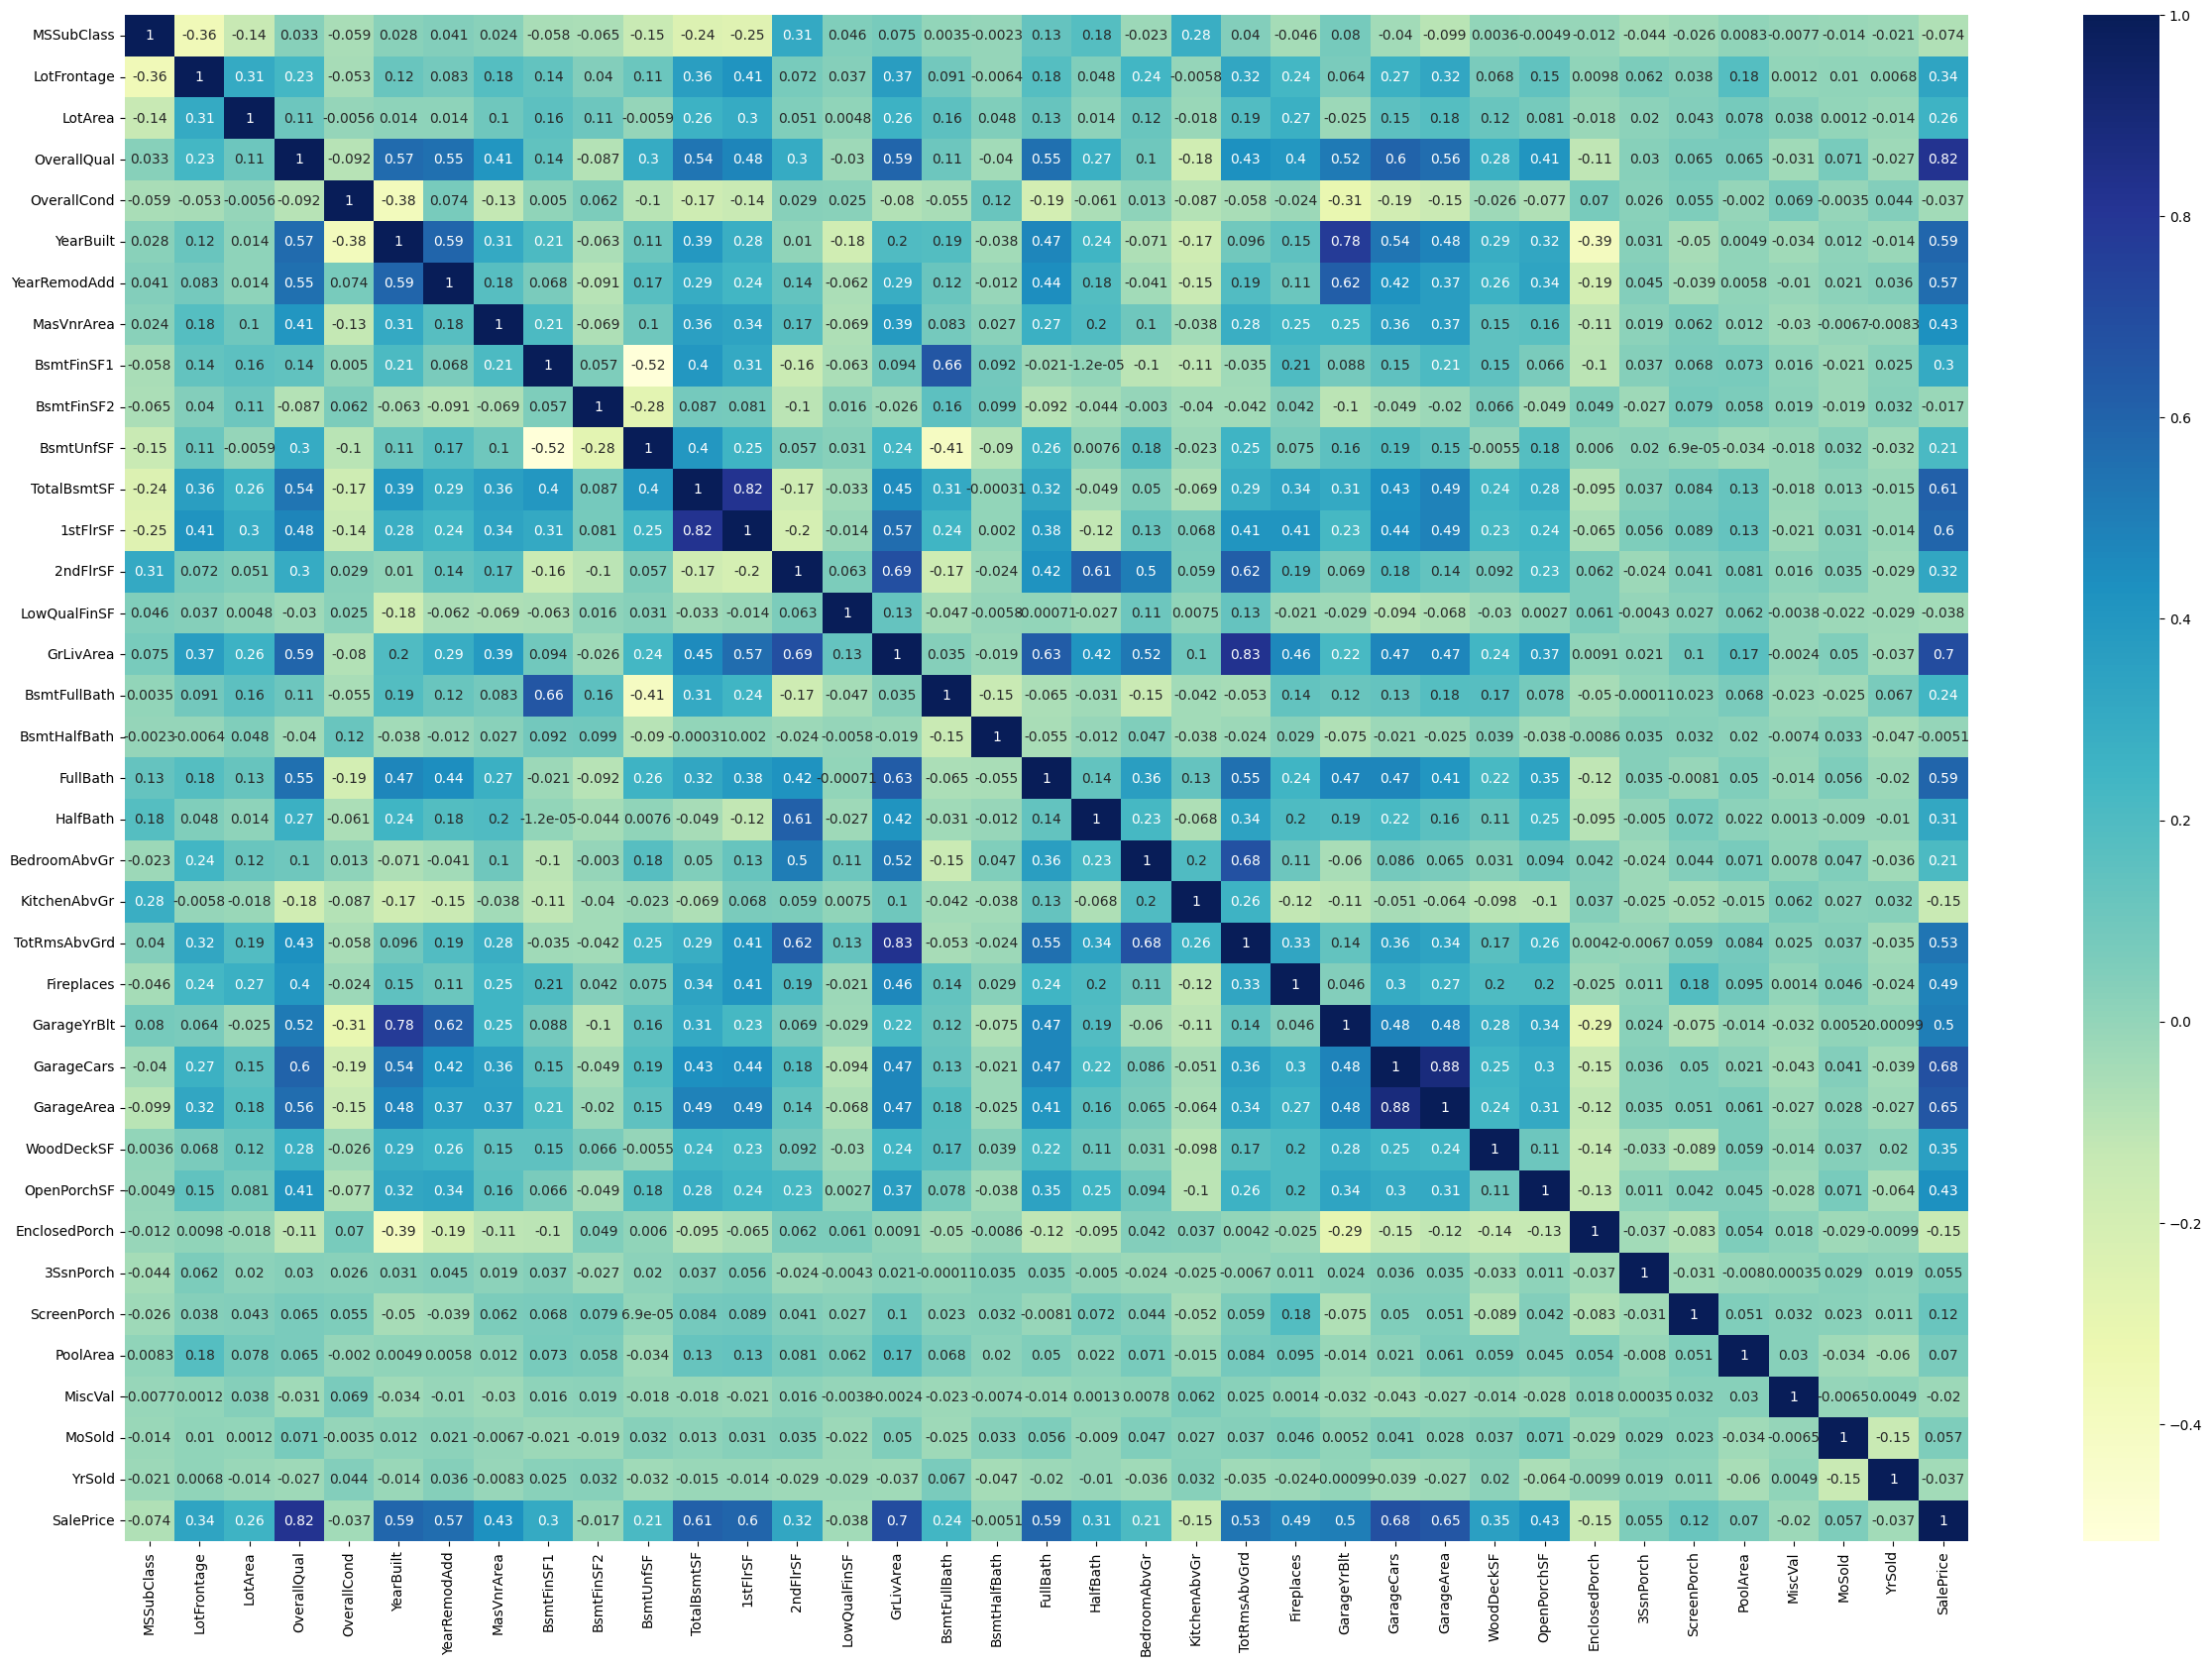

In [46]:
# figure size
plt.figure(figsize=(30,20))

# heatmap
sns.heatmap(transform_df.corr(), cmap="YlGnBu", annot=True)
plt.show()

We can see that some of the variables are correlated
Before dropping these columns, we will first check their predictive power

/home/mohit/Python/base/lib/python3.10/site-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


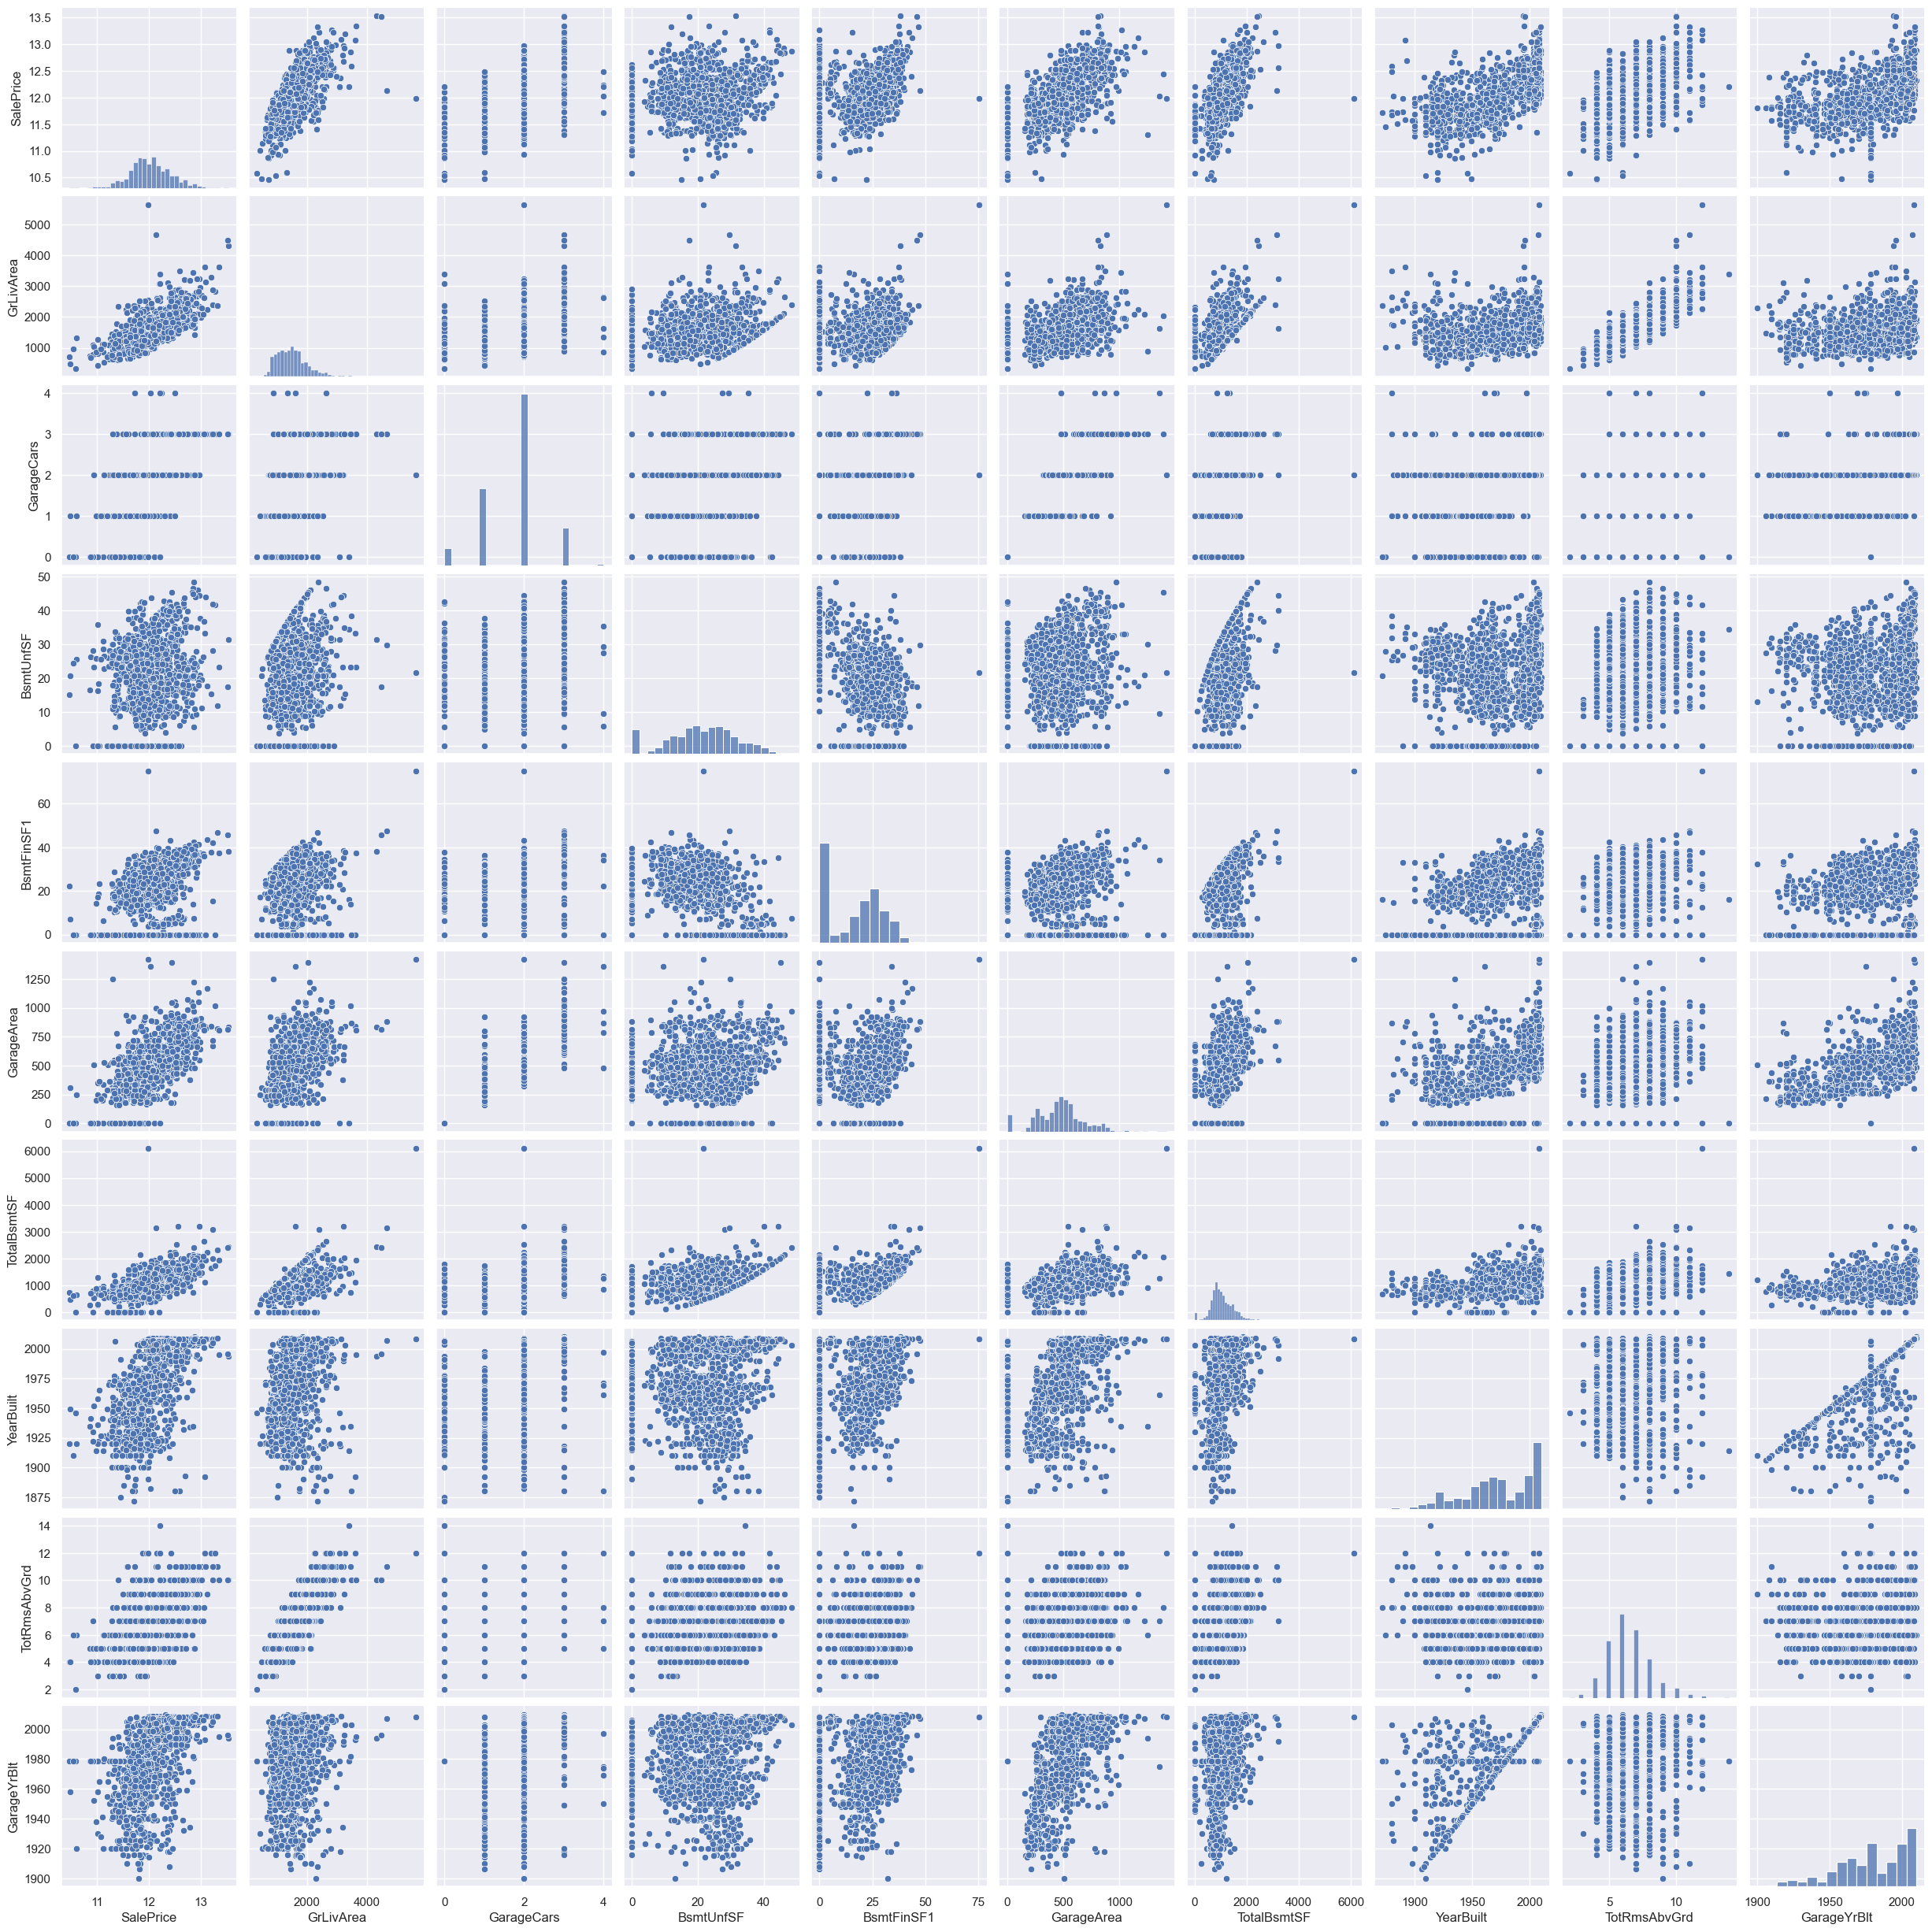

In [47]:
# Checking the same with a pairplot 
sns.set()
cols = ['SalePrice', 'GrLivArea', 'GarageCars', 'BsmtUnfSF', 'BsmtFinSF1', 'GarageArea', 'TotalBsmtSF', 'YearBuilt', 'TotRmsAbvGrd', 'GarageYrBlt']
sns.pairplot(transform_df[cols], size = 2.5)
plt.show()

### Droping Outliers

In [48]:
def removing_outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    value = q3-q1
    lower_value  = q1-2.5*value
    higer_value = q3+2.5*value
    
    out= df[(df[col]<=higer_value) & (df[col]>=lower_value)]
    return out


In [50]:
drop_df = copy.deepcopy(transform_df)
for col in extream_outliers.index:
    if transform_df[col].mean()>10:
        drop_df = removing_outliers(drop_df, col)    

**Data prepration for model**

In [51]:
#type of each feature in data: int, float, object
data = copy.deepcopy(transform_df)
types = data.dtypes
#numerical values are either type int or float
numeric_type = types[(types == 'int64') | (types == float)] 
#categorical values are type object
categorical_type = types[types == object]

In [52]:
pd.DataFrame(types).reset_index().set_index(0).reset_index()[0].value_counts()

object     43
int64      28
float64     9
Name: 0, dtype: int64

In [53]:
#we should convert numeric_type to a list to make it easier to work with
numerical_columns = list(numeric_type.index)
print(numerical_columns)

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


In [54]:
#Categorical columns
categorical_columns = list(categorical_type.index)
print(categorical_columns)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [55]:
# Creating Dummy columns to convert categorical into numerical
data = pd.get_dummies(data, drop_first=True )
data.head()

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0          60         65.0     8450            7            5       2003   
1          20         80.0     9600            6            8       1976   
2          60         68.0    11250            7            5       2001   
3          70         60.0     9550            7            5       1915   
4          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLI  \
0          2003       196.0   26.570661         0.0  ...               0   
1          1976         0.0   31.272992         0.0  ...               0   
2          2002       162.0   22.045408         0.0  ...               0   
3          1970         0.0   14.696938         0.0  ...               0   
4          2000       350.0   25.592968         0.0  ...               0   

   SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
0               0             0             0            1   
1               0             0             0            1   
2               0             0             0            1   
3               0             0             0            1   
4               0             0             0            1   

   SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                      0                     0                     0   
1                      0                     0                     0   
2                      0                     0                     0   
3                      0                     0                     0   
4                      0                     0                     0   

   SaleCondition_Normal  SaleCondition_Partial  
0                     1                      0  
1                     1                      0  
2                     1                      0  
3                     0                      0  
4                     1                      0  

[5 rows x 260 columns]

In [56]:
X = data.drop(['SalePrice'], axis=1)
X.head()

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0          60         65.0     8450            7            5       2003   
1          20         80.0     9600            6            8       1976   
2          60         68.0    11250            7            5       2001   
3          70         60.0     9550            7            5       1915   
4          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLI  \
0          2003       196.0   26.570661         0.0  ...               0   
1          1976         0.0   31.272992         0.0  ...               0   
2          2002       162.0   22.045408         0.0  ...               0   
3          1970         0.0   14.696938         0.0  ...               0   
4          2000       350.0   25.592968         0.0  ...               0   

   SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
0               0             0             0            1   
1               0             0             0            1   
2               0             0             0            1   
3               0             0             0            1   
4               0             0             0            1   

   SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                      0                     0                     0   
1                      0                     0                     0   
2                      0                     0                     0   
3                      0                     0                     0   
4                      0                     0                     0   

   SaleCondition_Normal  SaleCondition_Partial  
0                     1                      0  
1                     1                      0  
2                     1                      0  
3                     0                      0  
4                     1                      0  

[5 rows x 259 columns]

In [57]:
# Putting response variable to y
y = data['SalePrice']
y.head()

0    12.247699
1    12.109016
2    12.317171
3    11.849405
4    12.429220
Name: SalePrice, dtype: float64

In [90]:
# Creating training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=50)

In [91]:
X_train

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
175           20    84.000000    12615            6            7       1950   
1408          70    60.000000     7740            4            7       1910   
1148          50    70.049958     5700            7            7       1926   
861          190    75.000000    11625            5            4       1965   
220           20    73.000000     8990            7            5       2006   
...          ...          ...      ...          ...          ...        ...   
1456          20    85.000000    13175            6            6       1978   
229          120    43.000000     3182            7            5       2005   
70            20    95.000000    13651            7            6       1973   
132           20    75.000000     7388            5            6       1959   
1313          60   108.000000    14774            9            5       1999   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLI  \
175           2001         0.0   21.840330    0.000000  ...               0   
1408          1950         0.0    0.000000    0.000000  ...               0   
1148          1950         0.0    0.000000    0.000000  ...               0   
861           1965         0.0   29.000000    0.000000  ...               0   
220           2006         0.0    0.000000    0.000000  ...               0   
...            ...         ...         ...         ...  ...             ...   
1456          1988       119.0   28.106939   12.767145  ...               0   
229           2006        16.0    4.000000    0.000000  ...               0   
70            1973      1115.0   43.358967    0.000000  ...               0   
132           2002         0.0   20.124612    0.000000  ...               0   
1313          1999       165.0    0.000000    0.000000  ...               0   

      SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
175                0             0             0            1   
1408               0             0             0            1   
1148               0             0             0            1   
861                0             0             0            1   
220                0             1             0            0   
...              ...           ...           ...          ...   
1456               0             0             0            1   
229                0             0             0            1   
70                 0             0             0            1   
132                0             0             0            1   
1313               0             0             0            1   

      SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
175                       0                     0                     0   
1408                      0                     0                     0   
1148                      0                     0                     0   
861                       0                     0                     0   
220                       0                     0                     0   
...                     ...                   ...                   ...   
1456                      0                     0                     0   
229                       0                     0                     0   
70                        0                     0                     0   
132                       0                     0                     0   
1313                      0                     0                     0   

      SaleCondition_Normal  SaleCondition_Partial  
175                      1                      0  
1408                     1                      0  
1148                     1                      0  
861                      1                      0  
220                      0                      1  
...                    ...                    ...  
1456                     1                      0  
229       

In [92]:
# Scaling data
from sklearn.preprocessing import MinMaxScaler

In [93]:
scaller = MinMaxScaler()

In [94]:
scaller.fit(X_train)

MinMaxScaler()

In [95]:
X_train[X_train.columns] = scaller.transform(X_train[X_train.columns])
X_test[X_test.columns] = scaller.transform(X_test[X_test.columns])


In [96]:
X_train

MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
175     0.000000     0.215753  0.052887     0.555556        0.750   0.555556   
1408    0.294118     0.133562  0.030101     0.333333        0.750   0.259259   
1148    0.176471     0.167979  0.020566     0.666667        0.750   0.377778   
861     1.000000     0.184932  0.048260     0.444444        0.375   0.666667   
220     0.000000     0.178082  0.035944     0.666667        0.500   0.970370   
...          ...          ...       ...          ...          ...        ...   
1456    0.000000     0.219178  0.055505     0.555556        0.625   0.762963   
229     0.588235     0.075342  0.008797     0.666667        0.500   0.962963   
70      0.000000     0.253425  0.057730     0.666667        0.625   0.725926   
132     0.000000     0.184932  0.028456     0.444444        0.625   0.622222   
1313    0.235294     0.297945  0.062979     0.888889        0.500   0.918519   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLI  \
175       0.850000    0.000000    0.290714    0.000000  ...             0.0   
1408      0.000000    0.000000    0.000000    0.000000  ...             0.0   
1148      0.000000    0.000000    0.000000    0.000000  ...             0.0   
861       0.250000    0.000000    0.386015    0.000000  ...             0.0   
220       0.933333    0.000000    0.000000    0.000000  ...             0.0   
...            ...         ...         ...         ...  ...             ...   
1456      0.633333    0.086357    0.374128    0.332541  ...             0.0   
229       0.933333    0.011611    0.053243    0.000000  ...             0.0   
70        0.383333    0.809144    0.577146    0.000000  ...             0.0   
132       0.866667    0.000000    0.267876    0.000000  ...             0.0   
1313      0.816667    0.119739    0.000000    0.000000  ...             0.0   

      SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
175              0.0           0.0           0.0          1.0   
1408             0.0           0.0           0.0          1.0   
1148             0.0           0.0           0.0          1.0   
861              0.0           0.0           0.0          1.0   
220              0.0           1.0           0.0          0.0   
...              ...           ...           ...          ...   
1456             0.0           0.0           0.0          1.0   
229              0.0           0.0           0.0          1.0   
70               0.0           0.0           0.0          1.0   
132              0.0           0.0           0.0          1.0   
1313             0.0           0.0           0.0          1.0   

      SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
175                     0.0                   0.0                   0.0   
1408                    0.0                   0.0                   0.0   
1148                    0.0                   0.0                   0.0   
861                     0.0                   0.0                   0.0   
220                     0.0                   0.0                   0.0   
...                     ...                   ...                   ...   
1456                    0.0                   0.0                   0.0   
229                     0.0                   0.0                   0.0   
70                      0.0                   0.0                   0.0   
132                     0.0                   0.0                   0.0   
1313                    0.0                   0.0                   0.0   

      SaleCondition_Normal  SaleCondition_Partial  
175                    1.0                    0.0  
1408                   1.0                    0.0  
1148                   1.0                    0.0  
861                    1.0                    0.0  
220                    0.0                    1.0  
...                    ...                    ...  
1456                   1.0                    0.0 

# Model Building and Evaluation

## Check the model using Linear Regression and RFE

In [97]:
# Running RFE 
# Since there are more than 250 variables for analysis, we will run RFE to select some that have high predictive power
lm = LinearRegression()
lm.fit(X_train, y_train)
 # running RFE for top 100 variables
rfe = RFE(lm, n_features_to_select = 100)            
rfe = rfe.fit(X_train, y_train)
    

In [98]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('MSSubClass', False, 149),
 ('LotFrontage', True, 1),
 ('LotArea', True, 1),
 ('OverallQual', True, 1),
 ('OverallCond', True, 1),
 ('YearBuilt', True, 1),
 ('YearRemodAdd', False, 11),
 ('MasVnrArea', False, 49),
 ('BsmtFinSF1', True, 1),
 ('BsmtFinSF2', False, 157),
 ('BsmtUnfSF', False, 57),
 ('TotalBsmtSF', True, 1),
 ('1stFlrSF', True, 1),
 ('2ndFlrSF', True, 1),
 ('LowQualFinSF', True, 1),
 ('GrLivArea', True, 1),
 ('BsmtFullBath', True, 1),
 ('BsmtHalfBath', False, 129),
 ('FullBath', False, 32),
 ('HalfBath', False, 40),
 ('BedroomAbvGr', False, 151),
 ('KitchenAbvGr', True, 1),
 ('TotRmsAbvGrd', False, 4),
 ('Fireplaces', False, 117),
 ('GarageYrBlt', False, 79),
 ('GarageCars', True, 1),
 ('GarageArea', True, 1),
 ('WoodDeckSF', False, 56),
 ('OpenPorchSF', False, 114),
 ('EnclosedPorch', False, 3),
 ('3SsnPorch', False, 17),
 ('ScreenPorch', False, 7),
 ('PoolArea', True, 1),
 ('MiscVal', True, 1),
 ('MoSold', False, 123),
 ('YrSold', False, 125),
 ('MSZoning_FV', True, 1)

In [102]:
#  Select the top 100 variables

col = X_train.columns[rfe.support_]
col

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'KitchenAbvGr', 'GarageCars', 'GarageArea',
       'PoolArea', 'MiscVal', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL',
       'MSZoning_RM', 'LotConfig_FR3', 'LandSlope_Sev', 'Neighborhood_Crawfor',
       'Neighborhood_MeadowV', 'Neighborhood_NWAmes', 'Neighborhood_StoneBr',
       'Condition1_Feedr', 'Condition1_Norm', 'Condition1_PosN',
       'Condition1_RRAn', 'Condition1_RRNe', 'Condition1_RRNn',
       'Condition2_PosA', 'Condition2_PosN', 'Condition2_RRAe',
       'Condition2_RRAn', 'BldgType_Twnhs', 'HouseStyle_2.5Fin',
       'RoofStyle_Mansard', 'RoofStyle_Shed', 'RoofMatl_CompShg',
       'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll',
       'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl',
       'Exterior1st_BrkComm', 'Exterior1st_BrkFace', 'Exterior1st_CBlock',
       

In [103]:
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

X_train_rfe = pd.DataFrame(X_train[col])

X_train_rfe.head()

# predict
y_train_pred = lm.predict(X_train)
metrics.r2_score(y_true=y_train, y_pred=y_train_pred)



0.9513402647529028

In [104]:
y_test_pred = lm.predict(X_test)
metrics.r2_score(y_true=y_test, y_pred=y_test_pred)


-6.635134727834016e+22

# Lasso and Ridge Regression

In [112]:
# Applying Lasso

# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}
lasso = Lasso()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 


Fitting 5 folds for each of 28 candidates, totalling 140 fits


/home/mohit/Python/base/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.424e-02, tolerance: 1.331e-02
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [113]:
X_train

MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
175     0.000000     0.215753  0.052887     0.555556        0.750   0.555556   
1408    0.294118     0.133562  0.030101     0.333333        0.750   0.259259   
1148    0.176471     0.167979  0.020566     0.666667        0.750   0.377778   
861     1.000000     0.184932  0.048260     0.444444        0.375   0.666667   
220     0.000000     0.178082  0.035944     0.666667        0.500   0.970370   
...          ...          ...       ...          ...          ...        ...   
1456    0.000000     0.219178  0.055505     0.555556        0.625   0.762963   
229     0.588235     0.075342  0.008797     0.666667        0.500   0.962963   
70      0.000000     0.253425  0.057730     0.666667        0.625   0.725926   
132     0.000000     0.184932  0.028456     0.444444        0.625   0.622222   
1313    0.235294     0.297945  0.062979     0.888889        0.500   0.918519   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLI  \
175       0.850000    0.000000    0.290714    0.000000  ...             0.0   
1408      0.000000    0.000000    0.000000    0.000000  ...             0.0   
1148      0.000000    0.000000    0.000000    0.000000  ...             0.0   
861       0.250000    0.000000    0.386015    0.000000  ...             0.0   
220       0.933333    0.000000    0.000000    0.000000  ...             0.0   
...            ...         ...         ...         ...  ...             ...   
1456      0.633333    0.086357    0.374128    0.332541  ...             0.0   
229       0.933333    0.011611    0.053243    0.000000  ...             0.0   
70        0.383333    0.809144    0.577146    0.000000  ...             0.0   
132       0.866667    0.000000    0.267876    0.000000  ...             0.0   
1313      0.816667    0.119739    0.000000    0.000000  ...             0.0   

      SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
175              0.0           0.0           0.0          1.0   
1408             0.0           0.0           0.0          1.0   
1148             0.0           0.0           0.0          1.0   
861              0.0           0.0           0.0          1.0   
220              0.0           1.0           0.0          0.0   
...              ...           ...           ...          ...   
1456             0.0           0.0           0.0          1.0   
229              0.0           0.0           0.0          1.0   
70               0.0           0.0           0.0          1.0   
132              0.0           0.0           0.0          1.0   
1313             0.0           0.0           0.0          1.0   

      SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
175                     0.0                   0.0                   0.0   
1408                    0.0                   0.0                   0.0   
1148                    0.0                   0.0                   0.0   
861                     0.0                   0.0                   0.0   
220                     0.0                   0.0                   0.0   
...                     ...                   ...                   ...   
1456                    0.0                   0.0                   0.0   
229                     0.0                   0.0                   0.0   
70                      0.0                   0.0                   0.0   
132                     0.0                   0.0                   0.0   
1313                    0.0                   0.0                   0.0   

      SaleCondition_Normal  SaleCondition_Partial  
175                    1.0                    0.0  
1408                   1.0                    0.0  
1148                   1.0                    0.0  
861                    1.0                    0.0  
220                    0.0                    1.0  
...                    ...                    ...  
1456                   1.0                    0.0 

In [114]:
# cv_results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results = cv_results[cv_results['param_alpha']<=1]
cv_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0       0.241099      0.044101         0.013888        0.001319      0.0001   
1       0.052793      0.023682         0.014370        0.004543       0.001   
2       0.022364      0.007195         0.009961        0.003498        0.01   
3       0.019274      0.009150         0.008753        0.002096        0.05   
4       0.026814      0.014156         0.023750        0.014085         0.1   

              params  split0_test_score  split1_test_score  split2_test_score  \
0  {'alpha': 0.0001}          -0.083719          -0.072722          -0.082214   
1   {'alpha': 0.001}          -0.089286          -0.081888          -0.087639   
2    {'alpha': 0.01}          -0.141902          -0.128546          -0.132806   
3    {'alpha': 0.05}          -0.214013          -0.195421          -0.221343   
4     {'alpha': 0.1}          -0.292576          -0.262833          -0.292734   

   split3_test_score  ...  mean_test_score  std_test_score  rank_test_score  \
0          -0.100801  ...        -0.084191        0.009152                1   
1          -0.100603  ...        -0.088990        0.006311                2   
2          -0.157071  ...        -0.139434        0.009862                3   
3          -0.246960  ...        -0.218757        0.016592                4   
4          -0.330792  ...        -0.292579        0.021997                5   

   split0_train_score  split1_train_score  split2_train_score  \
0           -0.059971           -0.062322           -0.060465   
1           -0.079053           -0.081912           -0.080308   
2           -0.134077           -0.136778           -0.135566   
3           -0.217862           -0.219500           -0.215359   
4           -0.294547           -0.289280           -0.290127   

   split3_train_score  split4_train_score  mean_train_score  std_train_score  
0           -0.059800           -0.059868         -0.060485         0.000947  
1           -0.075857           -0.079261         -0.079278         0.001988  
2           -0.134178           -0.134807         -0.135081         0.001001  
3           -0.215342           -0.217485         -0.217110         0.001588  
4           -0.290384           -0.292463         -0.291360         0.001906  

[5 rows x 21 columns]

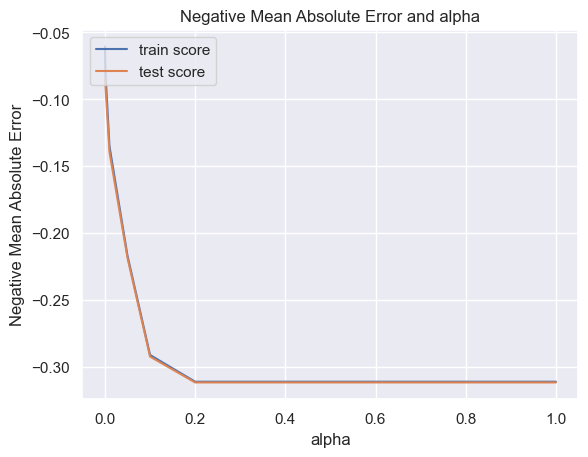

In [115]:


# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()



From the above graph we can see that the Negative Mean Absolute Error is quite low at alpha = 0.4 and stabilises thereafter,
but we will choose a low value of alpha to balance the trade-off between Bias-Variance
and to get the coefficients of smallest of features.

In [133]:
# lasso regression
lm = Lasso(alpha=0.01)
lm.fit(X_train, y_train)

# prediction on the test set(Using R2)
y_train_pred = lm.predict(X_train)
print(metrics.r2_score(y_true=y_train, y_pred=y_train_pred))
y_test_pred = lm.predict(X_test)
print(metrics.r2_score(y_true=y_test, y_pred=y_test_pred))

0.7733931650360661
0.7532070586481581


In [134]:
# lasso model parameters
model_parameters = list(lm.coef_ )
model_parameters.insert(0, lm.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = X.columns
cols = cols.insert(0, "constant")
list(zip(cols, model_parameters))


[('constant', 11.552),
 ('MSSubClass', -0.0),
 ('LotFrontage', 0.0),
 ('LotArea', 0.0),
 ('OverallQual', 0.526),
 ('OverallCond', 0.0),
 ('YearBuilt', 0.0),
 ('YearRemodAdd', 0.145),
 ('MasVnrArea', 0.0),
 ('BsmtFinSF1', 0.0),
 ('BsmtFinSF2', 0.0),
 ('BsmtUnfSF', 0.0),
 ('TotalBsmtSF', 0.0),
 ('1stFlrSF', 0.0),
 ('2ndFlrSF', 0.0),
 ('LowQualFinSF', 0.0),
 ('GrLivArea', 0.0),
 ('BsmtFullBath', 0.0),
 ('BsmtHalfBath', -0.0),
 ('FullBath', 0.044),
 ('HalfBath', 0.0),
 ('BedroomAbvGr', 0.0),
 ('KitchenAbvGr', -0.0),
 ('TotRmsAbvGrd', 0.126),
 ('Fireplaces', 0.0),
 ('GarageYrBlt', 0.0),
 ('GarageCars', 0.279),
 ('GarageArea', 0.0),
 ('WoodDeckSF', 0.0),
 ('OpenPorchSF', 0.0),
 ('EnclosedPorch', -0.0),
 ('3SsnPorch', 0.0),
 ('ScreenPorch', 0.0),
 ('PoolArea', 0.0),
 ('MiscVal', -0.0),
 ('MoSold', 0.0),
 ('YrSold', -0.0),
 ('MSZoning_FV', 0.0),
 ('MSZoning_RH', 0.0),
 ('MSZoning_RL', 0.042),
 ('MSZoning_RM', -0.05),
 ('Street_Pave', -0.0),
 ('Alley_None', 0.0),
 ('Alley_Pave', -0.0),
 ('LotSh

In [135]:
# Creating a dataframe for the coefficients obtained from Lasso
mod = list(zip(cols, model_parameters))


In [136]:
para = pd.DataFrame(mod)
para.columns = ['Variable', 'Coeff']

In [137]:
# Chose variables whose coefficients are non-zero
pred = pd.DataFrame(para[(para['Coeff'] != 0)])
pred

Variable   Coeff
0             constant  11.552
4          OverallQual   0.526
7         YearRemodAdd   0.145
19            FullBath   0.044
23        TotRmsAbvGrd   0.126
26          GarageCars   0.279
39         MSZoning_RL   0.042
40         MSZoning_RM  -0.050
46        LotShape_Reg  -0.038
104  HouseStyle_2Story   0.009
107    RoofStyle_Gable  -0.027
109      RoofStyle_Hip   0.009
149    MasVnrType_None  -0.020
153       ExterQual_TA  -0.057
159   Foundation_PConc   0.040
171    BsmtExposure_Gd   0.021
173    BsmtExposure_No  -0.002
176   BsmtFinType1_GLQ   0.044
180   BsmtFinType1_Unf  -0.010
196       CentralAir_Y   0.009
203     KitchenQual_TA  -0.053
211     FireplaceQu_Gd   0.001
212   FireplaceQu_None  -0.137
215  GarageType_Attchd   0.026
223   GarageFinish_Unf  -0.009

In [138]:
Lassso_var = list(pred['Variable'])
print(Lassso_var)


['constant', 'OverallQual', 'YearRemodAdd', 'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'MSZoning_RL', 'MSZoning_RM', 'LotShape_Reg', 'HouseStyle_2Story', 'RoofStyle_Gable', 'RoofStyle_Hip', 'MasVnrType_None', 'ExterQual_TA', 'Foundation_PConc', 'BsmtExposure_Gd', 'BsmtExposure_No', 'BsmtFinType1_GLQ', 'BsmtFinType1_Unf', 'CentralAir_Y', 'KitchenQual_TA', 'FireplaceQu_Gd', 'FireplaceQu_None', 'GarageType_Attchd', 'GarageFinish_Unf']


In [140]:
X_train_lasso = X_train[['GrLivArea', 'OverallQual', 'OverallCond', 'TotalBsmtSF', 'GarageArea', 'BsmtFinSF1', 'Fireplaces', 'LotArea', 'LotFrontage', 'BsmtFullBath', 'Foundation_PConc', 'OpenPorchSF', 'FullBath', 'ScreenPorch', 'WoodDeckSF']]           
X_train_lasso.head()


GrLivArea  OverallQual  OverallCond  TotalBsmtSF  GarageArea  \
175    0.343632     0.555556        0.750     0.196727    0.406206   
1408   0.193858     0.333333        0.750     0.101800    0.372355   
1148   0.146383     0.666667        0.750     0.093617    0.203103   
861    0.132818     0.444444        0.375     0.170049    0.355430   
220    0.219292     0.666667        0.500     0.245172    0.476023   

      BsmtFinSF1  Fireplaces   LotArea  LotFrontage  BsmtFullBath  \
175     0.290714    0.333333  0.052887     0.215753      0.333333   
1408    0.000000    0.000000  0.030101     0.133562      0.000000   
1148    0.000000    0.333333  0.020566     0.167979      0.000000   
861     0.386015    0.000000  0.048260     0.184932      0.333333   
220     0.000000    0.000000  0.035944     0.178082      0.000000   

      Foundation_PConc  OpenPorchSF  FullBath  ScreenPorch  WoodDeckSF  
175                0.0     0.240352  0.666667     0.000000    0.000000  
1408               0.0     0.000000  0.333333     0.436364    0.000000  
1148               1.0     0.000000  0.333333     0.000000    0.000000  
861                1.0     0.000000  0.333333     0.000000    0.000000  
220                1.0     0.256392  0.666667     0.000000    0.723796

In [141]:
X_train_lasso.shape

(1021, 15)

## Ridge Regression

In [142]:
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}


ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [143]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results = cv_results[cv_results['param_alpha']<=5]
cv_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0       0.037759      0.008846         0.017197        0.005308      0.0001   
1       0.039890      0.015987         0.014091        0.003944       0.001   
2       0.020290      0.006604         0.011851        0.003642        0.01   
3       0.030708      0.005160         0.015746        0.009474        0.05   
4       0.046835      0.023077         0.016899        0.008096         0.1   

              params  split0_test_score  split1_test_score  split2_test_score  \
0  {'alpha': 0.0001}          -0.088522          -0.088376          -0.089890   
1   {'alpha': 0.001}          -0.088510          -0.087939          -0.088627   
2    {'alpha': 0.01}          -0.088721          -0.085489          -0.087270   
3    {'alpha': 0.05}          -0.090198          -0.082801          -0.085605   
4     {'alpha': 0.1}          -0.091498          -0.080722          -0.084950   

   split3_test_score  ...  mean_test_score  std_test_score  rank_test_score  \
0          -0.111453  ...        -0.093692        0.008910               21   
1          -0.111742  ...        -0.093378        0.009209               19   
2          -0.110666  ...        -0.092254        0.009294               17   
3          -0.108896  ...        -0.090876        0.009318               13   
4          -0.107620  ...        -0.090444        0.009273               12   

   split0_train_score  split1_train_score  split2_train_score  \
0           -0.056188           -0.057810           -0.056522   
1           -0.056198           -0.057892           -0.056613   
2           -0.056433           -0.058143           -0.056810   
3           -0.057244           -0.058993           -0.057493   
4           -0.058013           -0.060058           -0.058524   

   split3_train_score  split4_train_score  mean_train_score  std_train_score  
0           -0.056360           -0.056409         -0.056658         0.000586  
1           -0.056437           -0.056423         -0.056713         0.000604  
2           -0.056647           -0.056585         -0.056924         0.000622  
3           -0.056978           -0.057327         -0.057607         0.000713  
4           -0.057253           -0.058145         -0.058399         0.000927  

[5 rows x 21 columns]

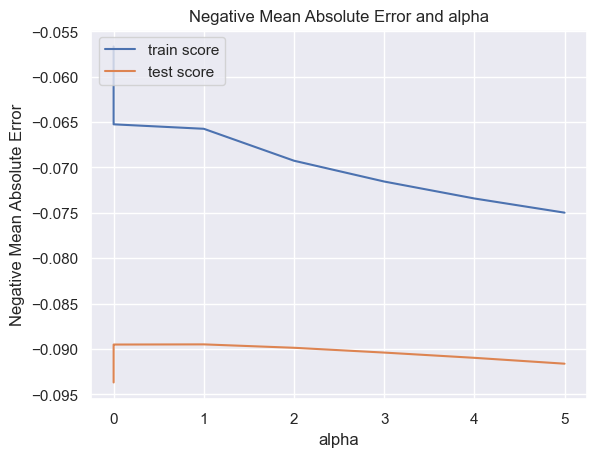

In [144]:


# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()



In [147]:

# since the Negative Mean Absolute Error stabilises at alpha = 2, we will choose this for further analysis

alpha = 2
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)

Ridge(alpha=2)

In [148]:
# ridge model parameters
model_parameters = list(ridge.coef_)
model_parameters.insert(0, ridge.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = X.columns
cols = cols.insert(0, "constant")
list(zip(cols, model_parameters))

[('constant', 10.628),
 ('MSSubClass', -0.042),
 ('LotFrontage', 0.022),
 ('LotArea', 0.144),
 ('OverallQual', 0.38),
 ('OverallCond', 0.244),
 ('YearBuilt', 0.114),
 ('YearRemodAdd', 0.088),
 ('MasVnrArea', 0.057),
 ('BsmtFinSF1', 0.161),
 ('BsmtFinSF2', 0.077),
 ('BsmtUnfSF', 0.056),
 ('TotalBsmtSF', 0.097),
 ('1stFlrSF', 0.281),
 ('2ndFlrSF', 0.204),
 ('LowQualFinSF', -0.004),
 ('GrLivArea', 0.309),
 ('BsmtFullBath', 0.096),
 ('BsmtHalfBath', -0.01),
 ('FullBath', 0.161),
 ('HalfBath', 0.054),
 ('BedroomAbvGr', 0.071),
 ('KitchenAbvGr', -0.083),
 ('TotRmsAbvGrd', 0.197),
 ('Fireplaces', 0.013),
 ('GarageYrBlt', -0.07),
 ('GarageCars', 0.183),
 ('GarageArea', 0.102),
 ('WoodDeckSF', 0.034),
 ('OpenPorchSF', 0.054),
 ('EnclosedPorch', 0.072),
 ('3SsnPorch', 0.073),
 ('ScreenPorch', 0.075),
 ('PoolArea', -0.016),
 ('MiscVal', -0.011),
 ('MoSold', -0.006),
 ('YrSold', -0.014),
 ('MSZoning_FV', 0.127),
 ('MSZoning_RH', 0.161),
 ('MSZoning_RL', 0.126),
 ('MSZoning_RM', 0.091),
 ('Street_P

In [150]:
# ridge regression
lm = Ridge(alpha=2)
lm.fit(X_train, y_train)

# predict
y_train_pred = lm.predict(X_train)
print(metrics.r2_score(y_true=y_train, y_pred=y_train_pred))
y_test_pred = lm.predict(X_test)
print(metrics.r2_score(y_true=y_test, y_pred=y_test_pred))

0.9359689969007018
0.8622247736352906


**It is visible that the model performance is better than Lasso. The train and the test scores are matching well**


In [153]:
# Create a dataframe for Ridge Coefficients
mod_ridge = list(zip(cols, model_parameters))

paraRFE = pd.DataFrame(mod_ridge)
paraRFE.columns = ['Variable', 'Coeff']


## since there were few coefficients at 0, we removed them from features
predRFE = pd.DataFrame(paraRFE[(paraRFE['Coeff'] != 0)])
predRFE


Variable   Coeff
0                 constant  10.628
1               MSSubClass  -0.042
2              LotFrontage   0.022
3                  LotArea   0.144
4              OverallQual   0.380
..                     ...     ...
255  SaleCondition_AdjLand   0.079
256   SaleCondition_Alloca   0.060
257   SaleCondition_Family   0.009
258   SaleCondition_Normal   0.068
259  SaleCondition_Partial   0.012

[251 rows x 2 columns]


# Observation:
- Though the model performance by Ridge Regression was better in terms of R2 values of Train and Test,
- It is better to use Lasso, since it brings and assigns a zero value to insignificant features, enabling us to choose
- The predictive variables.
- It is always advisable to use simple yet robust model.
- Equation can be formulated using the features and coefficients obtained by Lasso

### These are the final features that should be selected for predicting the price of house

### Hence the equation:
    
####    Log(Y) = C + 0.125(x1) + 0.112(x2) +  0.050(x3) + 0.042(x4) + 0.035(x5) + 0.034(x6) + 0.024(x7) +  0.015(x8) + 0.014(x9) + 0.010(x10)
####                + 0.010(x11) + 0.005(x12) - 0.007(x13) - 0.007(x14) - 0.008(x15) - 0.095(x16) + Error term(RSS + alpha * (sum of absolute value of coefficients)

### INFERENCE


#### Suggestions for Surprise Housing is to keep a check on these predictors affecting the price of the house.

#### The higher values of positive coeeficients suggest a high sale value.

#### Some of those features are:-
 |  Feature  |  Description  |
 |  ---  |  ---  |
 |  GrLivArea  |  Above grade (ground) living area square feet  |
 |  OverallQual  |  Rates the overall material and finish of the house  |
 |  OverallCond  |  Rates the overall condition of the house  |
 |  TotalBsmtSF  |  Total square feet of basement area  |
 |  GarageArea   |Size of garage in square feet  |
        
#### The higher values of negative coeeficients suggest a decrease in sale value.

#### Some of those features are:-
   |  Feature  |  Description  |
   |  ---  |  ---  |
   |  PropAge  |  Age of the property at the time of seeling  |
   |  MSSubClass  |  Identifies the type of dwelling involved in the sale  |
    

#### When the market value of the property is lower than the Predicted Sale Price, its the time to buy.



